# Application of a genetic algorithm on a Neural Network using Tensorflow - Malware detection with Machine Learning
The goal of this notebook is to achieve a **classification** in order to **detect Android malwares**. The process will be to feed forward an **Artificial Neural Network** with a pre-processed and clean dataset of Java Bytecode, and predict if it is **benign or not**. 

Then, we apply a **genetic algorithm** with the aim of getting the most optimized parameters for the neural network.

In [1]:
%reset -f 

> **Tensorflow** will be used for building and training the neural network,  
> **Pandas** for the first data processing and visualization,   
> **Matplotlib** (with **Seaborn backend**) will be used to plot the results of the ANN

In [2]:
import genev # genetic algorithm
from genev import Individual, Evolution

import os
import sys
import time
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.utils import shuffle
from datetime import timedelta
from numpy import linalg as LA
from IPython.display import SVG, display

sns.set()   # Set seaborn as backend
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Hide messy TensorFlow warnings
%matplotlib inline
%config InlineBackend.figure_format = "retina" # Enhance matplotlib on hdpi displays
%autonotify --after 30

## Import the dataset
The dataset contains supposedly contains **5541** Android Malwares and **2166** benign applications. The input/output shape for each item is **5971/2**. 

In [3]:
path = "./android-features.data"

In [4]:
count = 0
_samples = None
_input_size, _output_size = None, None 
_raw_inputs, _raw_outputs = [], []

with open(path) as f:
    for line in f:
        
        count += 1
        
        # Parse string data to float
        data = [float(i) for i in line.split()]
        
        # Read header
        if _samples is None:
            _samples = int(data[0])
            _input_size = int(data[1])
            _output_size = int(data[2])
            continue
            
        if count % 2 == 0:
            _raw_inputs.append(data)
        else:
            _raw_outputs.append(data)
        
_raw_inputs = np.asarray(_raw_inputs)
_raw_outputs = np.asarray(_raw_outputs)

Check that we correctly have the right shapes of data. The shapes of the array will confirm us if we loaded correctly all data:

In [5]:
print("_samples", _samples)
print("_input_size", _input_size)
print("_output_size", _output_size)
print("_raw_inputs.shape", _raw_inputs.shape)
print("_raw_outputs.shape", _raw_outputs.shape)

_samples 7707
_input_size 5971
_output_size 2
_raw_inputs.shape (7707, 5971)
_raw_outputs.shape (7707, 2)


## Analysis of the data
Our objective is to get knowledge about the data that we manipulate and, for example, verify that the inputs are **normalized** as well as the outputs. 

In [6]:
df = pd.DataFrame(_raw_inputs)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970
0,0.000000,0.00000,0.000275,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.029498,0.061378,0.033071,0.036460,0.050385,0.106724,0.041774,0.135672,0.058721,0.037651
1,0.000000,0.00000,0.000000,0.0,0.000335,0.000000,0.0,0.000000,0.000000,0.000000,...,0.025469,0.083780,0.031166,0.036528,0.061662,0.105228,0.054960,0.171917,0.057306,0.045576
2,0.000013,0.00009,0.000000,0.0,0.000013,0.000013,0.0,0.000013,0.000013,0.000000,...,0.031334,0.047353,0.035140,0.029078,0.022517,0.110379,0.039792,0.138919,0.041612,0.026272
3,0.000018,0.00000,0.000055,0.0,0.000000,0.000009,0.0,0.000009,0.000018,0.000046,...,0.035820,0.081835,0.022787,0.031889,0.044527,0.092903,0.033469,0.100370,0.043728,0.023393
4,0.000011,0.00008,0.000023,0.0,0.000011,0.000011,0.0,0.000011,0.000023,0.000000,...,0.030828,0.046942,0.037359,0.027488,0.022576,0.104237,0.042742,0.133000,0.039941,0.025916


In [7]:
df = pd.DataFrame(_raw_outputs)
df.head()

,0,1
0,0.95,0.05
1,0.95,0.05
2,0.95,0.05
3,0.95,0.05
4,0.95,0.05


## Cross validation datasets creation
As we can see above, the data is not equally divided in the dataset: it is sorted by class (malware first, benign last).   
Thus, we can start by **shuffling the dataset**:

In [8]:
X_all, y_all = shuffle(_raw_inputs, _raw_outputs, random_state=0)

For performance purpose, we will take only **10% of the dataset** in order to speedup the overall  process. 

In [9]:
# part = 0.1 # take a small part
part = 1.0 # when we're done with testing
size = X_all.shape[0]

X_data = X_all[: int(size * part)]
y_data = y_all[: int(size * part)]

Then, we need to split it 3 parts with 3 different purpose: 
- The **training dataset** - 60% (*gain knowledge*)
- The **validation dataset** - 20% (*validate the ability of generalizing*)
- The **test dataset** - 20% (*test the accuracy*)   

In [10]:
def cross_validation_split(X, y):
    validation_part = 0.20
    test_part = 0.20
    train_part = 1 - validation_part - test_part

    size = X.shape[0]

    # Create cross-validation datasets
    X_train = X[: int(size * train_part)]
    y_train = y[: int(size * train_part)]

    X_val = X[X_train.shape[0]: X_train.shape[0] + int(size * validation_part)]
    y_val = y[y_train.shape[0]: y_train.shape[0] + int(size * validation_part)]

    X_test = X[-int(size * test_part):]
    y_test = y[-int(size * test_part):]

    print("X_.shape\t", X.shape, "\t", "y_.shape\t", y.shape)
    print("X_train.shape\t", X_train.shape, "\t", "y_train.shape\t", y_train.shape)
    print("X_val.shape\t", X_val.shape, "\t", "y_val.shape\t", y_val.shape)
    print("X_test.shape\t", X_test.shape, "\t", "y_test.shape\t", y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = cross_validation_split(X_data, y_data)

X_.shape	 (7707, 5971) 	 y_.shape	 (7707, 2)
X_train.shape	 (4624, 5971) 	 y_train.shape	 (4624, 2)
X_val.shape	 (1541, 5971) 	 y_val.shape	 (1541, 2)
X_test.shape	 (1541, 5971) 	 y_test.shape	 (1541, 2)


### Analysis of the malware/benign distribution
Now that we have shuffled our data and splitted our data, we need to check that it is correctly distributed:

,"(0.95, 0.05)","(0.05, 0.95)"
y_data,5541,2166
y_train,3337,1287
y_val,1102,439
y_test,1101,440


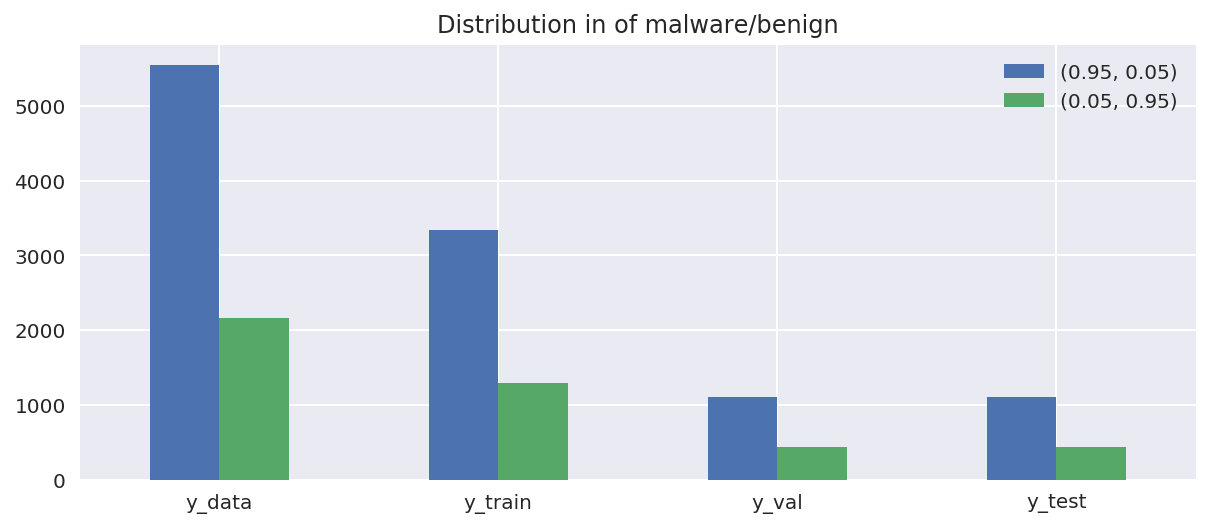

In [11]:
def frame(dataset, label):
    
    df = pd.DataFrame(dataset)
    columns = [() for _ in range(df.shape[1])]
    values = [None for _ in range(df.shape[1])]

    for n in df:
        for i, item in enumerate(df[n].value_counts().items()):
            columns[i] += (item[0],)
            values[i] = item[1]

    df = pd.DataFrame([values], index=[label], columns=columns)
    return df
    
df1 = frame(y_data, "y_data")
df2 = frame(y_train, "y_train")
df3 = frame(y_val, "y_val")
df4 = frame(y_test, "y_test")

df = pd.concat([df1, df2, df3, df4])
display(df)

hist = df.plot.bar(rot=0, figsize=(10, 4))
hist.set_title("Distribution in of malware/benign")
plt.show()

Thanks to this histogram, we are now sure that each set is representative of our global data.

## Build the model

<a style="float:right" href="https://en.wikipedia.org/wiki/Sensitivity_and_specificity#/media/File:Sensitivity_and_specificity.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" width="250px">"Sensitivity and specificity", from Wikipedia</a>
As well as we do a classification, the purpose of the test dataset is to ensure that the classification is correct.  
The following is implemented under `Model.test(, X, Y)`

> **True positive** (TP): correctly identified   
    *We predicted "malware" and the true class is "malware"*  

> **False positive** (FP): incorrectly identified   
    *We predicted "not malware" and the true class is "not malware"*
        
> **True negative** (TN): correctly rejected    
    *We predicted "malware" and the true class is "not malware"*

> **False negative** (FN): incorrectly rejected     
    *We predicted "not malware" and the true class is "malware"*
    
The following measures can be calculated:
* **Accuracy**
* **Misclassification Error** (or Error Rate)
* **Receiver Operating Characteristic** (ROC)

More info on http://mlwiki.org/index.php/Evaluation_of_Binary_Classifiers#Accuracy_and_Error_Rate   

We decide to classify the neural network output as a malware if its output 0 is greater than the output 1.    
The following function illustrates that, given a `tuple` as parameter:

In [12]:
def is_malware(value : tuple):
    return True if value[0] > value[1] else False # ex: 0.91 > 0.12 means it is categorized as a malware

We register the model as a class in order to produce as many copies of this model as we want for soon generating each population of a our genetic algorithm.   
Here are most important methods:
* `__init__()` take all hyperparameters that will be dynamically modified by the genetic algorithm as arguments
* `build()` creates the Tensorflow graph given the model's hyperparameters
* `train_on_batch()` optimizes the internal weights of the model given the data and the `batch_size` (it can be 1)
* `validate_on_batch()` returns metrics of the current model tested on the given data and the batch size
* `fit()` calls `train_on_batch()` on the whole training set and validate its performance on the validation set each `epochs_between_reports`
* `test()` return metrics of the current model tested on the test set

In [16]:
class Model():

    def __init__(self, learning_rate=0.01, momentum=0.9, lr_decay=0.0, hidden_layers=3, hidden_size_1=1, hidden_size_2=1, hidden_size_3=1, activation="linear"):
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.lr_decay = lr_decay
        self.hidden_layers = hidden_layers
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3
        self.activation = activation
        
        self.train_losses = []
        self.validation_losses = []
        self.metrics = []
        self.times = []
        self.training_time = None

        self.status = "live" # other values are messages
        self.aborted = False
        self.epochs_between_reports = 10
        self.desired_error = 0.001
        
        # Initialize session
        self.build(X_data.shape[1], y_data.shape[1])
        
    def build(self, input_shape, output_shape):
        
        tf.reset_default_graph()
        self.graph = tf.Graph()
        
        if self.hidden_layers < 0:
            self.status = "not_suitable"
            self.aborted = True
            return 

        with self.graph.as_default():
            with tf.variable_scope("Core_layers"):

                # Pick between available activations
                activations = {"linear": None, "sigmoid": tf.nn.sigmoid, "tanh": tf.nn.tanh, "relu": tf.nn.relu}
                activation = activations[self.activation]
                
                # Input dense layer
                x = tf.placeholder(tf.float32, shape=(None, input_shape))
                y = tf.placeholder(tf.float32, shape=(None, output_shape))

                # 3 hidden_layers
                layers = [tf.layers.dense(inputs=x, units=self.hidden_size_1, activation=activation)]
                layers.append(tf.layers.dense(inputs=layers[-1], units=self.hidden_size_2, activation=activation))
                layers.append(tf.layers.dense(inputs=layers[-1], units=self.hidden_size_3, activation=activation))

                # Output layer 
                output = tf.layers.dense(inputs=layers[-1], units=output_shape, activation=activation)

                # Loss function (MSE)
                loss = tf.losses.mean_squared_error(labels=y, predictions=output)

                # Optimize the loss minimization
                optimizer = tf.train.RMSPropOptimizer(self.learning_rate, momentum=self.momentum, decay=self.lr_decay)
                #optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
                train_op = optimizer.minimize(loss)

                # Add variables as params to be accessible in the whole object
                self.x = x
                self.y = y
                self.output = output
                self.loss = loss
                self.train_op = train_op
                self.sess = tf.Session()

                assert loss.graph is self.graph
            
    def train_on_batch(self, X, Y, batch_size=None, train=True):
        
        dataset_size = X.shape[0]
        batch_size = dataset_size if batch_size is None else batch_size

        assert batch_size > 0 and batch_size <= dataset_size, \
            "The batch size must be either None or an integer between zero and the dataset size (batch_size={})".format(batch_size)
        
        with self.graph.as_default():
            
            # Get variables from the building
            x, y = self.x, self.y
            loss, train_op = self.loss, self.train_op
            
            # Compute dataset windows corresponding to the batch size
            windows = zip(range(0, dataset_size, batch_size), range(batch_size, dataset_size+1, batch_size))

            start_time = time.time()
            losses = []

            # Fetch by window of dataset[start:end]
            for start, end in windows:
                
                loss_t = self.sess.run([loss, train_op] if train is True else [loss], {x: X, y: Y})
                
                if not np.isfinite(loss_t[0]):
                    self.status = "stopped: the loss is gone to infinite values"
                    self.aborted = True
                    break
                    
                losses.append(loss_t[0])

            # Return the mean loss and elapsed time for this epoch    
            return np.mean(losses), time.time() - start_time     
        
    def validate_on_batch(self, X, Y, batch_size=1):
        
        # Call train function but with train=False option
        return self.train_on_batch(X, Y, batch_size, train=False)
    
    def fit(self, X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, batch_size=None, early_stopping=True, verbose=False):

        if epochs % self.epochs_between_reports != 0:
            print("Warning: it is recommended to set a number of `epochs` divisible by the `epochs_between_reports`")
        
        with self.graph.as_default():

            train_losses = []
            validation_losses = []
            metrics = []
            times = []
            
            # Initialize weights and biais
            self.sess.run(tf.global_variables_initializer())

            # Fetch the dataset through epochs
            for i in range(1, epochs+1):

                # Train & save metrics
                loss, t = self.train_on_batch(X_train, Y_train, batch_size)
                train_losses.append(loss)
                times.append(t)
                
                if self.aborted:
                    break

                # Validate, test and fire early stopping if necessary
                if i % self.epochs_between_reports == 0:

                    # Validate
                    val_loss, t = self.validate_on_batch(X_validation, Y_validation, batch_size)
                    validation_losses.append(val_loss)
                    
                    # Test and save metrics
                    test_metrics = self.test(X_test, Y_test)
                    acc = test_metrics["accuracy"]
                    metrics.append(test_metrics)
                    
                    # Early Stopping
                    if early_stopping:
                        if len(validation_losses) > 2 and val_loss > validation_losses[-2]:
                            self.status = "early_stopped: val_loss gone up"
                            self.aborted = True
                        if val_loss < self.desired_error:
                            self.status = "early_stopped: desired error reached"
                            sefl.aborted = True
                        
                    if verbose is True:
                        print("epoch #{0:}\tloss: {1:.4f} / {2:.4f}\tacc: {3:.2f}".format(i, loss, val_loss, acc))
                    
            # Save the metrics
            self.train_losses = np.asarray(train_losses)
            self.validation_losses = np.asarray(validation_losses)
            self.metrics = np.asarray(metrics)
            self.times = np.asarray(times)
            self.training_time = np.sum(times)

            return self.train_losses, self.validation_losses, self.metrics, self.times
    
    def test(self, X, Y):
        
        with self.graph.as_default():
            classes = [(0.95, 0.05), (0.05, 0.95)]
        
            # Predict
            predicted = self.sess.run([self.output], {self.x: X})
            predicted = np.asarray(predicted[0])
            expected = Y

            # Establish the count of TP, TN, FP, FN
            TP, TN, FP, FN = 0, 0, 0, 0
            n_malwares = 0
            for pred, exp in zip(predicted, expected):
                n_malwares += 1 if is_malware(exp) else 0
                TP += 1 if is_malware(pred) and is_malware(exp) else 0
                TN += 1 if not is_malware(pred) and not is_malware(exp) else 0
                FP += 1 if is_malware(pred) and not is_malware(exp) else 0
                FN += 1 if not is_malware(pred) and is_malware(exp) else 0
                
            # Compute the rates
            accuracy = (TP + TN) / len(expected)
            error = 1 - accuracy
            TPR = TP / (TP + FN)
            FPR = FP / (FP + TN)
                
            return {
                "accuracy": accuracy,
                "error": error,
                "true_positive": TP,
                "true_negative": TN,
                "true_positive_rate": TPR,
                "false_positive": FP,
                "false_negative": FN,
                "false_positive_rate": FPR
            }
            
    def display_losses(self, figsize=(12, 4)):
        
        train, val = np.asarray(self.train_losses), np.asarray(self.validation_losses)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        x_axis = np.arange(len(val))/float(len(val)-1)*(len(train)-1)

        for ax in (ax1, ax2):
            data = [train, val] if ax == ax1 else [np.log(train), np.log(val)]
            ax.plot(data[0], label="Train")
            ax.plot(x_axis, data[1], label="Validation")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")

        plt.suptitle("model losses after {}s".format(str(timedelta(seconds=self.training_time))), fontsize=16, y=1.10)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def display_metrics(self, figsize=(8, 4)):
        
        acc = np.asarray([m["accuracy"] for m in self.metrics])
        
        # We also add the points (0, 0) and (1, 1)
        fpr = np.asarray([0, 1] + [m["false_positive_rate"] for m in self.metrics])
        tpr = np.asarray([0, 1] + [m["true_positive_rate"] for m in self.metrics])
        
        # Sort fpr
        p = fpr.argsort()
        fpr, tpr = fpr[p], tpr[p]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
        ax1.plot(acc, label="accuracy", color="orange")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy")
        
        ax2.plot([0, 1], [0, 1], "--", color="gray")
        ax2.plot(fpr, tpr, "-r", zorder=1)
        ax2.scatter(fpr, tpr, marker=",", label="tpr/fpr", color=(0.8, 0, 0), s=10, zorder=2)
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        
        plt.suptitle("metrics after {}s".format(str(timedelta(seconds=self.training_time))), fontsize=16, y=1.10)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def free(self):
        with self.graph.as_default():
            self.sess.close()    
        
    def __delete__(self):
        self.free()

## The training part
At this point, we can create a model given the right parameters and test its performance.

In [17]:
params = {'activation': 'tanh',
          'learning_rate': 0.0028803199879704213,
          'lr_decay': 0.06169868522111648,
          'momentum': 0.4612098539149855}

In [18]:
m1 = Model(**params)
m1.epochs_between_reports = 20

Train the model. For a more precise result, `batch_size=1` is better. For a quick result, `batch_size=None` will proceed the whole passed data as a batch.

In [19]:
train_losses, val_loss, metrics, t = m1.fit(X_train, y_train, X_val, y_val, X_test, y_test, epochs=1000, batch_size=None, early_stopping=False, verbose=True)

epoch #20	loss: 0.2460 / 0.2398	acc: 0.29
epoch #40	loss: 0.1753 / 0.1753	acc: 0.71
epoch #60	loss: 0.1627 / 0.1651	acc: 0.71
epoch #80	loss: 0.1621 / 0.1643	acc: 0.71
epoch #100	loss: 0.1587 / 0.1604	acc: 0.71
epoch #120	loss: 0.1475 / 0.1478	acc: 0.71
epoch #140	loss: 0.1371 / 0.1373	acc: 0.83
epoch #160	loss: 0.1275 / 0.1273	acc: 0.83
epoch #180	loss: 0.1125 / 0.1117	acc: 0.84
epoch #200	loss: 0.0893 / 0.0913	acc: 0.87
epoch #220	loss: 0.0711 / 0.0770	acc: 0.89
epoch #240	loss: 0.0610 / 0.0684	acc: 0.91
epoch #260	loss: 0.0545 / 0.0626	acc: 0.92
epoch #280	loss: 0.0497 / 0.0584	acc: 0.92
epoch #300	loss: 0.0458 / 0.0548	acc: 0.92
epoch #320	loss: 0.0424 / 0.0518	acc: 0.92
epoch #340	loss: 0.0393 / 0.0491	acc: 0.93
epoch #360	loss: 0.0366 / 0.0467	acc: 0.93
epoch #380	loss: 0.0341 / 0.0445	acc: 0.94
epoch #400	loss: 0.0318 / 0.0425	acc: 0.94
epoch #420	loss: 0.0298 / 0.0407	acc: 0.94
epoch #440	loss: 0.0279 / 0.0391	acc: 0.94
epoch #460	loss: 0.0262 / 0.0377	acc: 0.95
epoch #480	loss

<IPython.core.display.Javascript object>

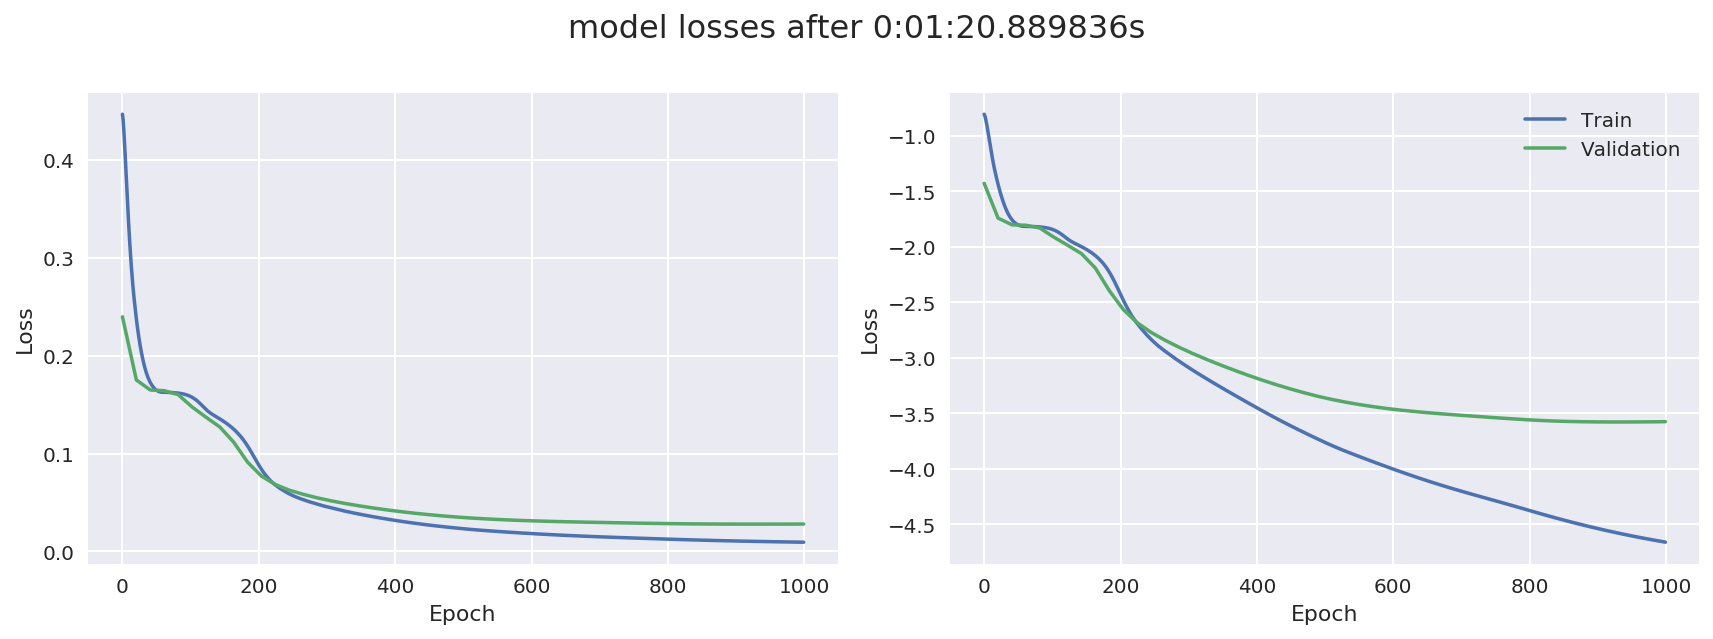

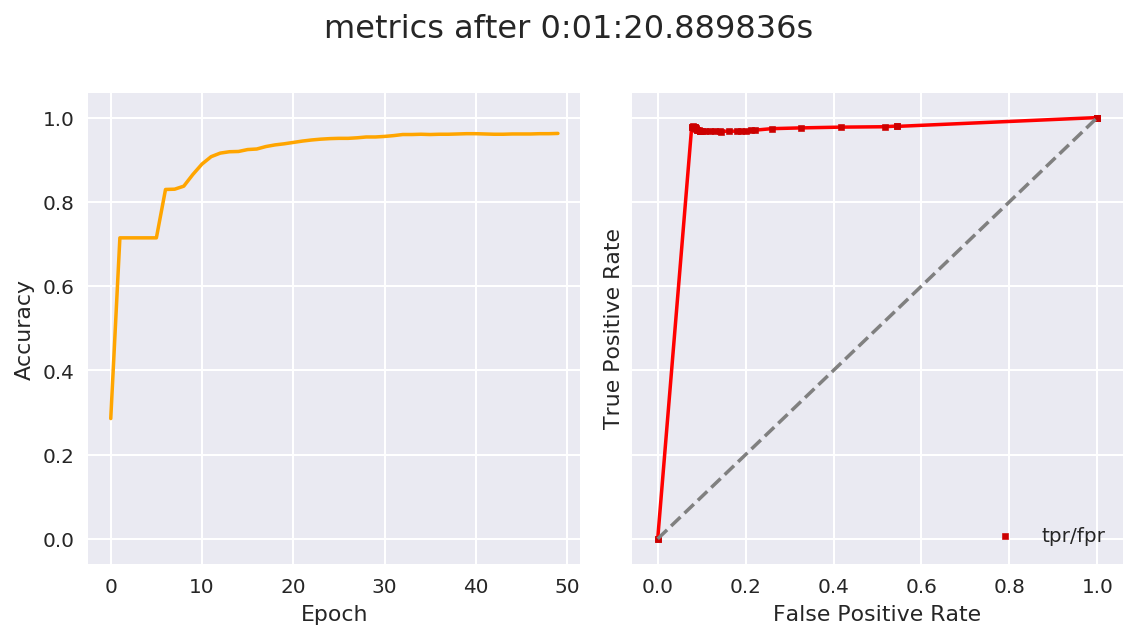

'live'

In [20]:
m1.display_losses()
m1.display_metrics()
m1.status

If the above status is "live", so it is possible to **continue the training** of the model **without overfitting it**. If not, `status` will output the reason why the training has stopped.   
Get the accuracy from the test set:

In [21]:
m1.test(X_test, y_test)

{'accuracy': 0.9623621025308241,
 'error': 0.037637897469175896,
 'false_negative': 23,
 'false_positive': 35,
 'false_positive_rate': 0.07954545454545454,
 'true_negative': 405,
 'true_positive': 1078,
 'true_positive_rate': 0.9791099000908265}

**/!\ Important:** do not forget to free the session, if not the memory will be huge in a while

In [22]:
#del m1

## Genetic algorithm configuration
### Configure the hyperparameters that can be changed
Each parameters should be associated with a tuple describing the expected value like `(value_type, picking_function)`.

In [23]:
hyperparameters = {
    "learning_rate": (float, lambda: 10 ** np.random.uniform(-4, 0)),
    "momentum": (float, lambda: np.random.uniform(0, 1)),
    "lr_decay": (float, lambda: 10 ** np.random.uniform(-6, 0)),
    "hidden_size_1": (int, lambda: np.round(np.random.uniform(1, 512))),
    "hidden_size_2": (int, lambda: np.round(np.random.uniform(1, 50))),
    "hidden_size_3": (int, lambda: np.round(np.random.uniform(1, 25))),
    "activation": (str, lambda: np.random.choice(["linear", "sigmoid", "tanh"]))
}

### Configure the fitness function
The fitness function is the most important here, because it is what **determines the score of an individual** and thus a generation. The more precise it is, the more you have control over how your individuals are chosen and the speed of the convergence towards a good generation. However the components must stay sufficiently "free" and simple to reveal the real power of random solution.  

While the goal is to have a low fitness, we set **1000** as a default component evaluated value. The components of the fitness are the following:
* The last **accuracy** (emphasized)
* The last **train loss**
* The last **test loss**
* The **time** for an epoch

In [24]:
def get_fitness_components(model) -> list:
    
    components = {
        "accuracy_emphasized": 1000, 
        "train_loss": 1000, 
        "validation_loss": 1000, 
        "mean_epoch_time": 1000
    }
    
    if model.aborted is True:
        return components
    
    if len(model.train_losses) < 0 or len(model.metrics) < 0 \
    or len(model.validation_losses) < 0 or len(model.times) < 0:
        return components;
    
    components["accuracy_emphasized"] = np.sqrt(1-model.metrics[-1]["accuracy"]) * 4
    components["train_loss"] = model.train_losses[-1] 
    components["validation_loss"] = model.validation_losses[-1] 
    components["mean_epoch_time"] = np.mean(model.times) 

    return components

def calc_fitness(model):
    
    epochs = 300
    model.fit(X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=None, early_stopping=True)   
    fitness = 0
    for value in get_fitness_components(model).values(): # add up all components  
        fitness += value
    
    return fitness

The accuracy is the most important component, this is why we set it as emphasized. Also, the goal is to make a distinction between a 0.97 and 0.98 of accuracy. Here's how we do, using the **squared root**:

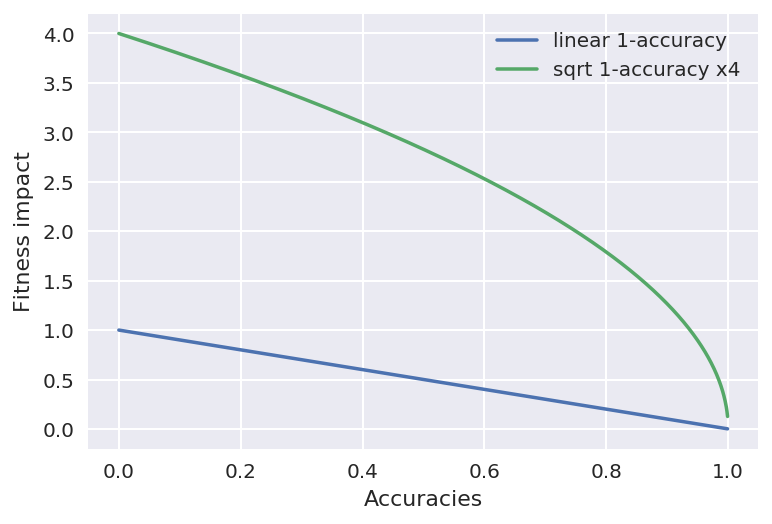

In [25]:
accuracies = np.arange(0, 1, 0.001)
emphasized = np.sqrt(1-accuracies) * 4

plt.plot(accuracies, 1-accuracies, label="linear 1-accuracy")
plt.plot(accuracies, emphasized, label="sqrt 1-accuracy x4")
plt.xlabel("Accuracies")
plt.ylabel("Fitness impact")
plt.legend()
plt.plot();

Then we can analyze how much each component of the fitness function was the most taken in account. Taking **m1**, for example:

In [26]:
m1_fitness = calc_fitness(m1)

In [27]:
def analyze_fitness_components(model):
    components = get_fitness_components(model)
    for name in components.keys():
        components[name] = [components[name], m1_fitness, "{:.1%}".format(components[name] / m1_fitness)]
    
    return pd.DataFrame(components, index=["value", "fitness", "percentage"])

analyze_fitness_components(m1)

,accuracy_emphasized,mean_epoch_time,train_loss,validation_loss
value,0.922711,0.0792444,0.0291075,0.0388709
fitness,1.06993,1.06993,1.06993,1.06993
percentage,86.2%,7.4%,2.7%,3.6%


### Define the callback function
This is an optional function that will be called after each evolution, mostly for display-purpose. The below function is responsible for showing the **training losses**, the **validation losses** and the **ROC curve** for each tested neural network.

In [28]:
def callback():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
    fpr, tpr = [0, 1], [0, 1]
    
    for p in ev.population:
        print(p)
        ax1.plot(p.obj.train_losses)
        ax2.plot(p.obj.validation_losses)
        
        if len(p.obj.metrics) > 0:
            metrics = p.obj.metrics[-1]
            fpr.append(metrics["false_positive_rate"])
            tpr.append(metrics["true_positive_rate"])
    
    fpr, tpr = np.asarray(fpr), np.asarray(tpr)
    p = fpr.argsort() # sort the points
    fpr, tpr = fpr[p], tpr[p]
    
    print(fpr.shape, tpr.shape)
    
    ax3.plot([0, 1], [0, 1], "--", color="gray")
    ax3.plot(fpr, tpr, "-r", zorder=1)
    ax3.scatter(fpr, tpr, marker=",", color=(0.8, 0, 0), s=10, zorder=2)
    ax3.set_xlabel("False Positive Rate")
    ax3.set_ylabel("True Positive Rate")
    
    ax1.set_title("Training losses")
    ax2.set_title("Validation losses")
    ax3.set_title("ROC curve")
    
    plt.show()

## Launch the genetic evolution 
Here's the command to reload the core module without reloading the whole notebook:

In [29]:
import importlib
importlib.reload(genev)

import genev
from genev import Evolution, Individual

### Create the initial population

In [30]:
ev = Evolution(10, structure=Model, dna_skeleton=hyperparameters)
ev.model(Model, hyperparameters, calc_fitness)
ev.create()

In [31]:
ev.evaluate(display=True);

evaluation: 100.00%	(10 over 10)


<IPython.core.display.Javascript object>

[#2 / gen 0]	score is 1.4491635529138707
[#9 / gen 0]	score is 1.866531602812653
[#8 / gen 0]	score is 2.5774139566115823
[#1 / gen 0]	score is 4000
[#3 / gen 0]	score is 4000
[#4 / gen 0]	score is 4000
[#5 / gen 0]	score is 4000
[#6 / gen 0]	score is 4000
[#7 / gen 0]	score is 4000
[#0 / gen 0]	score is 9223372036854775807
(11,) (11,)


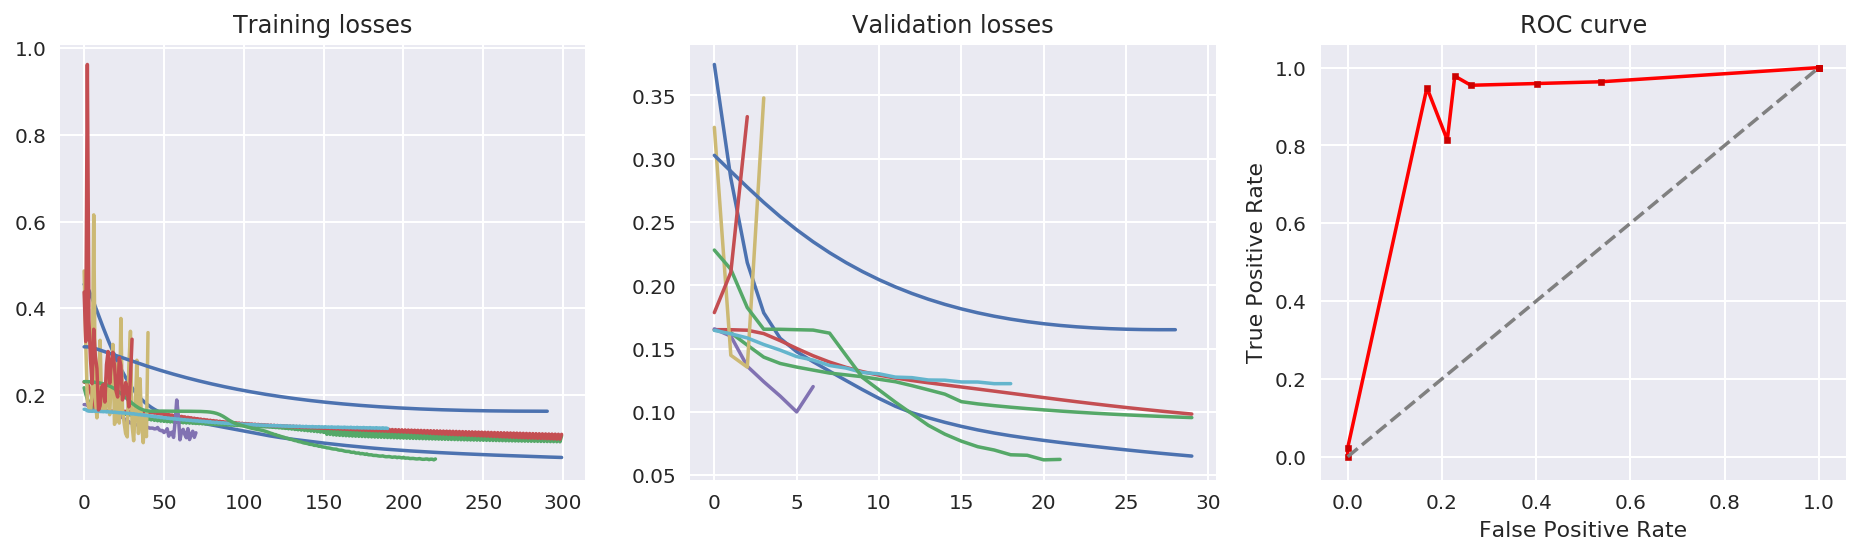

In [32]:
callback();

### Evolve the population
Evolving the population can take some time. Here are some stats for training on **10% of the whole dataset**, with `batch_size` of the size of the input dataset:   

For 300 epochs each and 10 individuals over 10 generations, it took like ~9min (`early_stopping=False`).   
For 300 epochs each and 15 individuals over 10 generations, it took like ~11min (`early_stopping=False`).   
For 300 epochs each and 15 individuals over 10 generations, it took like ~7min (`early_stopping=True`).   
For 300 epochs each and 15 individuals over 20 generations, it took like ~24min (`early_stopping=True`).   

> On a **dedicated server** (8 cores instead of 4):   
> For 300 epochs each and 15 individuals over 30 generations, it took like ~22min (`early_stopping=True`).   
> The result was not better.   

A few ideas in order to improve the time of the generations:
* Start with an estimation of a good generation


0 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#2 / gen 0]	score is 1.4491635529138707
[#0 / gen 0]	score is 1.4639197713736634
[#8 / gen 0]	score is 2.5480515994322412
[#10 / gen 1]	score is 5.163161384896342
[#9 / gen 0]	score is 4000
[#1 / gen 0]	score is 4000
[#11 / gen 1]	score is 4000
[#12 / gen 1]	score is 9223372036854775807
[#13 / gen 1]	score is 9223372036854775807
[#14 / gen 1]	score is 9223372036854775807
(8,) (8,)


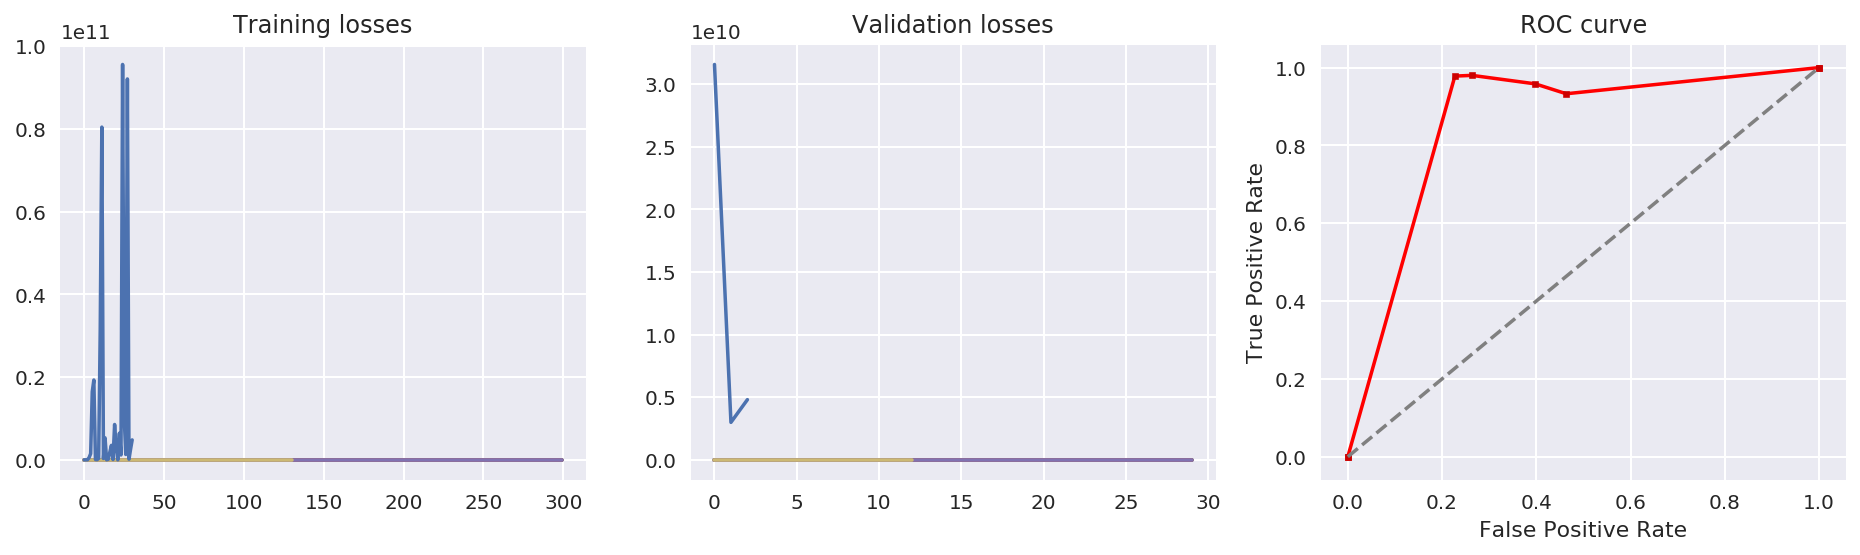

1 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#0 / gen 0]	score is 1.3847561618804105
[#12 / gen 1]	score is 1.4360421655334972
[#2 / gen 0]	score is 1.4491635529138707
[#16 / gen 2]	score is 1.7420676744686143
[#14 / gen 1]	score is 2.3422914096505196
[#8 / gen 0]	score is 2.4967815520071617
[#15 / gen 2]	score is 4000
[#17 / gen 2]	score is 9223372036854775807
[#18 / gen 2]	score is 9223372036854775807
[#19 / gen 2]	score is 9223372036854775807
(9,) (9,)


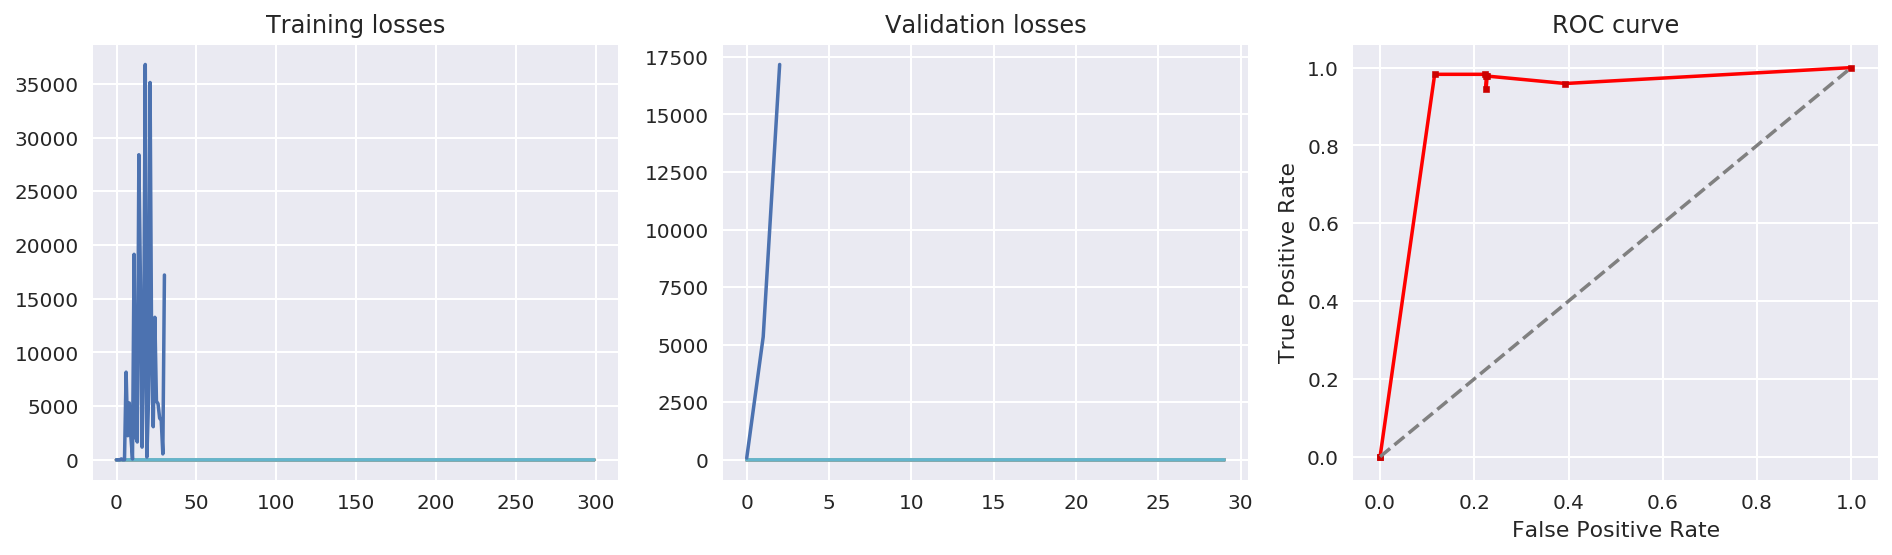

2 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#12 / gen 1]	score is 1.3635440426503442
[#0 / gen 0]	score is 1.3847561618804105
[#2 / gen 0]	score is 1.409063705044369
[#16 / gen 2]	score is 1.717282101828599
[#17 / gen 2]	score is 2.139581268603948
[#20 / gen 3]	score is 2.2765661086073647
[#21 / gen 3]	score is 4000
[#22 / gen 3]	score is 9223372036854775807
[#23 / gen 3]	score is 9223372036854775807
[#24 / gen 3]	score is 9223372036854775807
(9,) (9,)


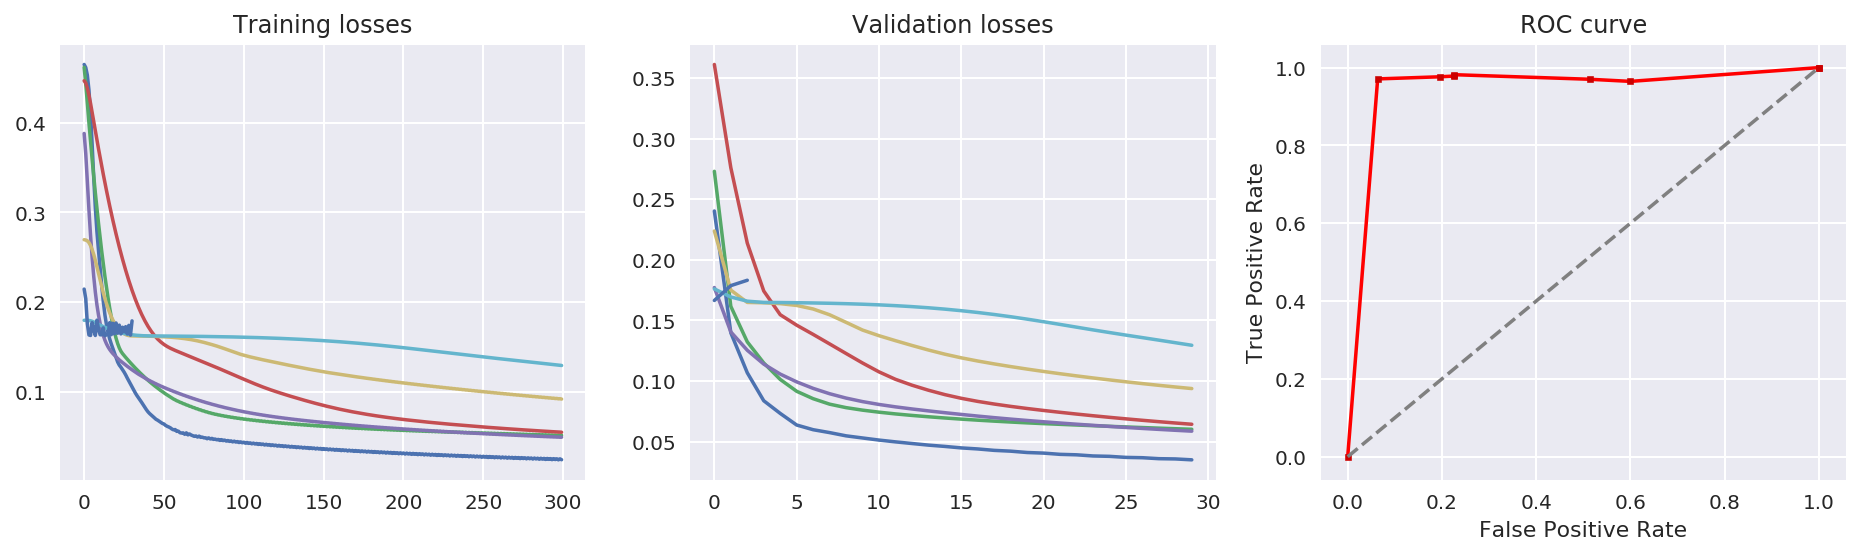

3 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#12 / gen 1]	score is 1.3635440426503442
[#2 / gen 0]	score is 1.4227080288151073
[#0 / gen 0]	score is 1.524500807237049
[#16 / gen 2]	score is 1.6778703174690817
[#17 / gen 2]	score is 2.1123526111906243
[#26 / gen 4]	score is 3.3829602852529423
[#25 / gen 4]	score is 4000
[#27 / gen 4]	score is 9223372036854775807
[#28 / gen 4]	score is 9223372036854775807
[#29 / gen 4]	score is 9223372036854775807
(9,) (9,)


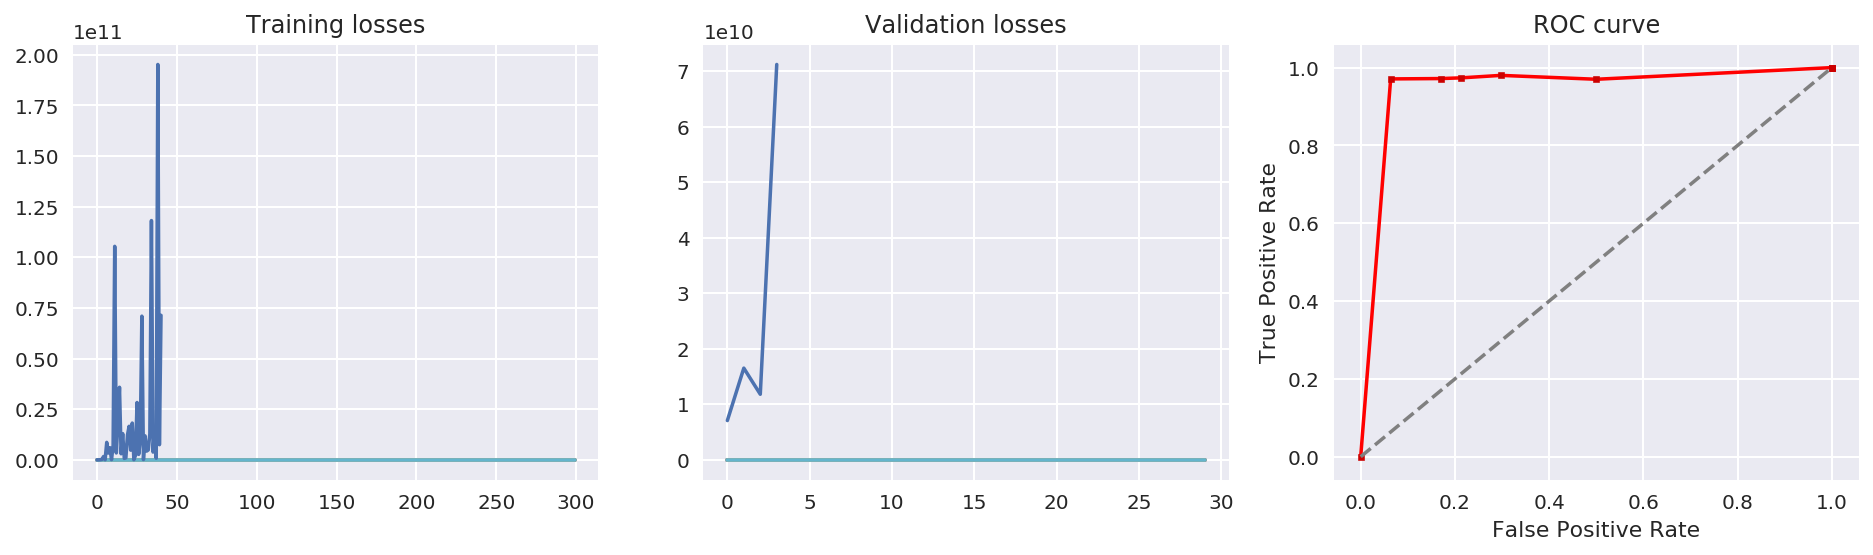

4 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#12 / gen 1]	score is 1.3635440426503442
[#2 / gen 0]	score is 1.3718067140202383
[#0 / gen 0]	score is 1.3746831974165719
[#31 / gen 5]	score is 1.4118339736458512
[#16 / gen 2]	score is 1.712922779687985
[#17 / gen 2]	score is 2.199681983075433
[#30 / gen 5]	score is 4000
[#32 / gen 5]	score is 9223372036854775807
[#33 / gen 5]	score is 9223372036854775807
[#34 / gen 5]	score is 9223372036854775807
(9,) (9,)


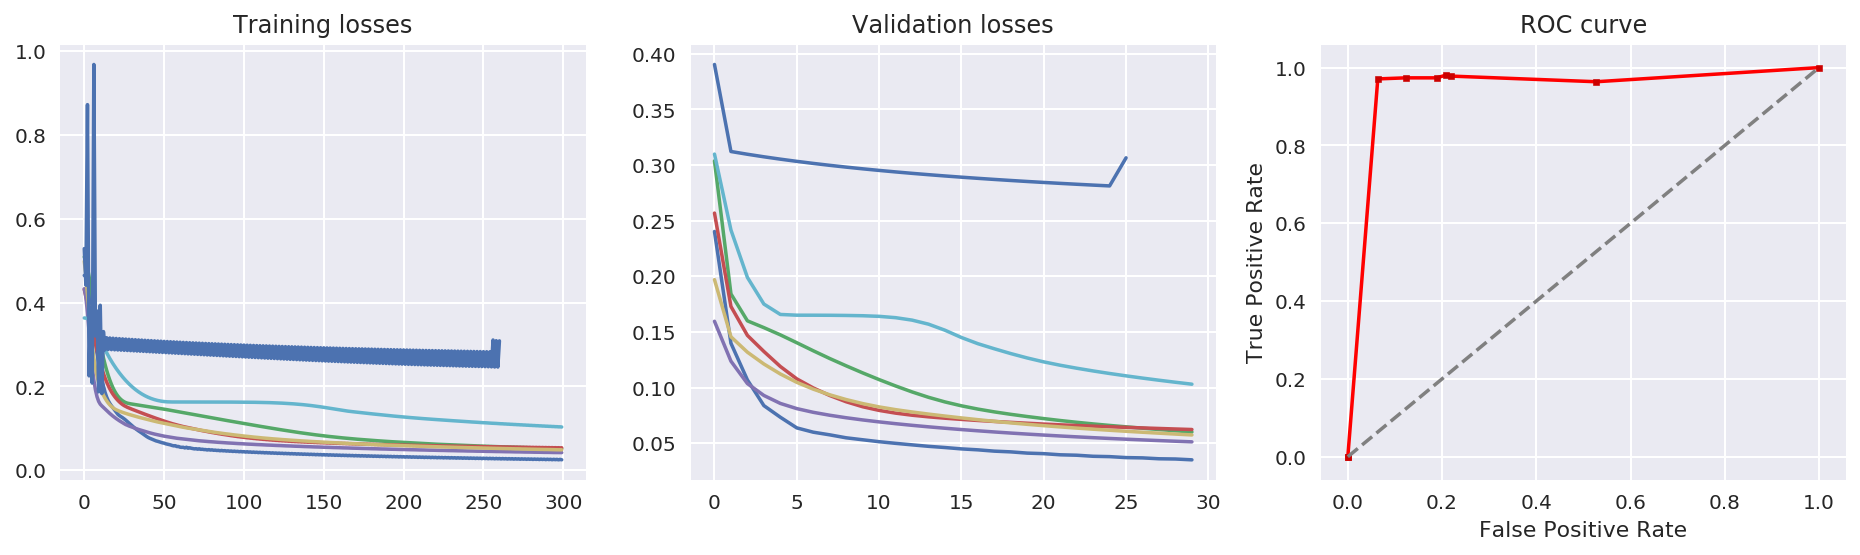

5 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#32 / gen 5]	score is 1.3013188967263063
[#12 / gen 1]	score is 1.3635440426503442
[#2 / gen 0]	score is 1.4059733179983578
[#0 / gen 0]	score is 1.4989448874320228
[#31 / gen 5]	score is 1.5732851175704154
[#35 / gen 6]	score is 4000
[#36 / gen 6]	score is 4000
[#37 / gen 6]	score is 9223372036854775807
[#38 / gen 6]	score is 9223372036854775807
[#39 / gen 6]	score is 9223372036854775807
(9,) (9,)


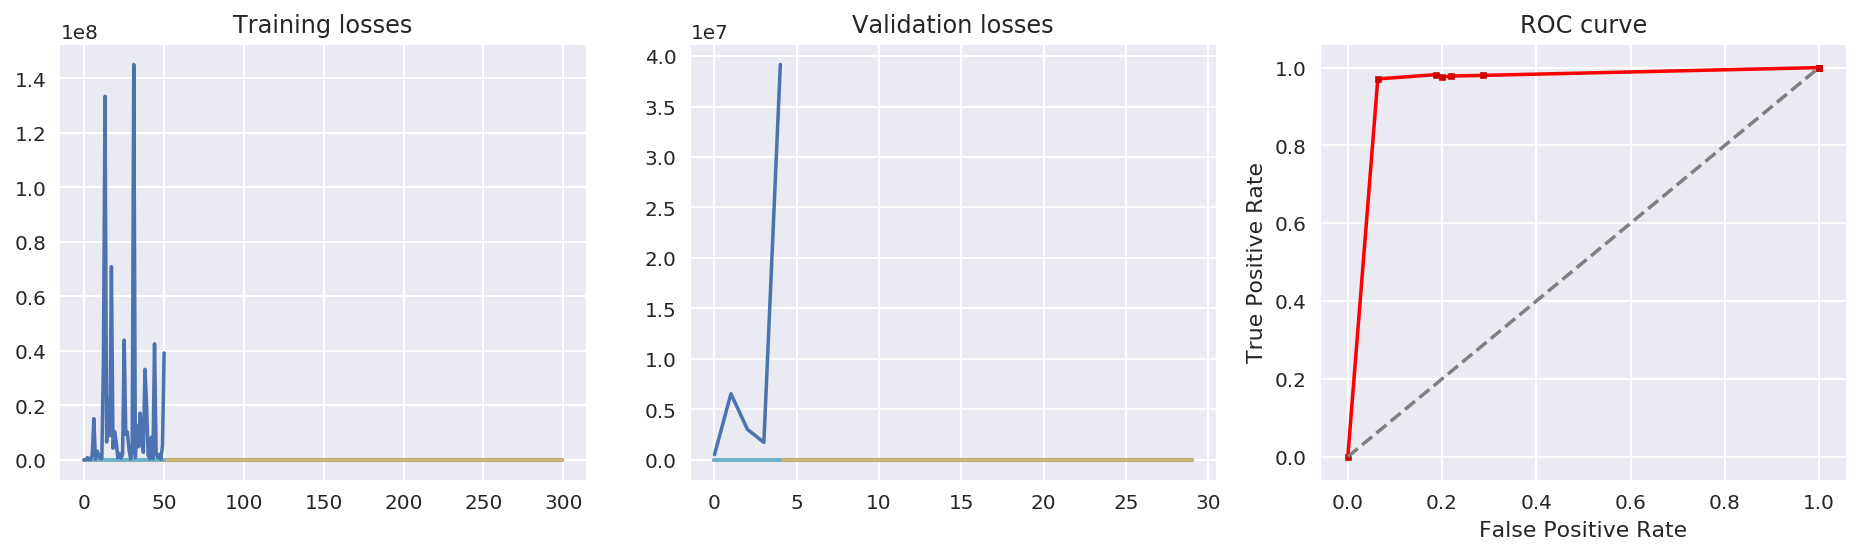

6 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#32 / gen 5]	score is 1.3013188967263063
[#31 / gen 5]	score is 1.3987567193292139
[#12 / gen 1]	score is 1.402425306240474
[#2 / gen 0]	score is 1.4142203556587096
[#0 / gen 0]	score is 1.5192116856484112
[#41 / gen 7]	score is 1.8587397112489654
[#40 / gen 7]	score is 4.609613847836327
[#42 / gen 7]	score is 9223372036854775807
[#43 / gen 7]	score is 9223372036854775807
[#44 / gen 7]	score is 9223372036854775807
(9,) (9,)


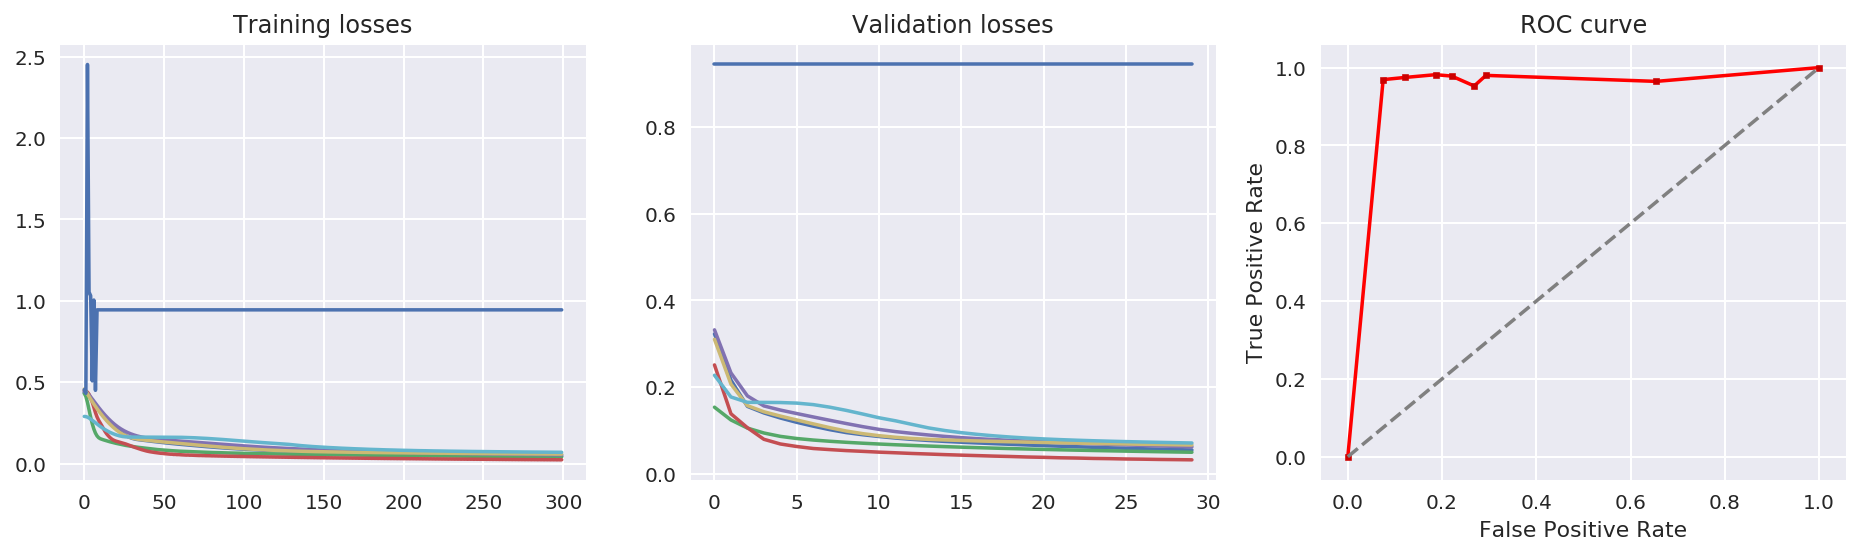

7 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#32 / gen 5]	score is 1.3013188967263063
[#2 / gen 0]	score is 1.3636907386473491
[#12 / gen 1]	score is 1.473596636461224
[#31 / gen 5]	score is 1.4976239004411702
[#0 / gen 0]	score is 1.5168143506257235
[#45 / gen 8]	score is 1.8686781131049055
[#46 / gen 8]	score is 2.195915683180747
[#47 / gen 8]	score is 9223372036854775807
[#48 / gen 8]	score is 9223372036854775807
[#49 / gen 8]	score is 9223372036854775807
(9,) (9,)


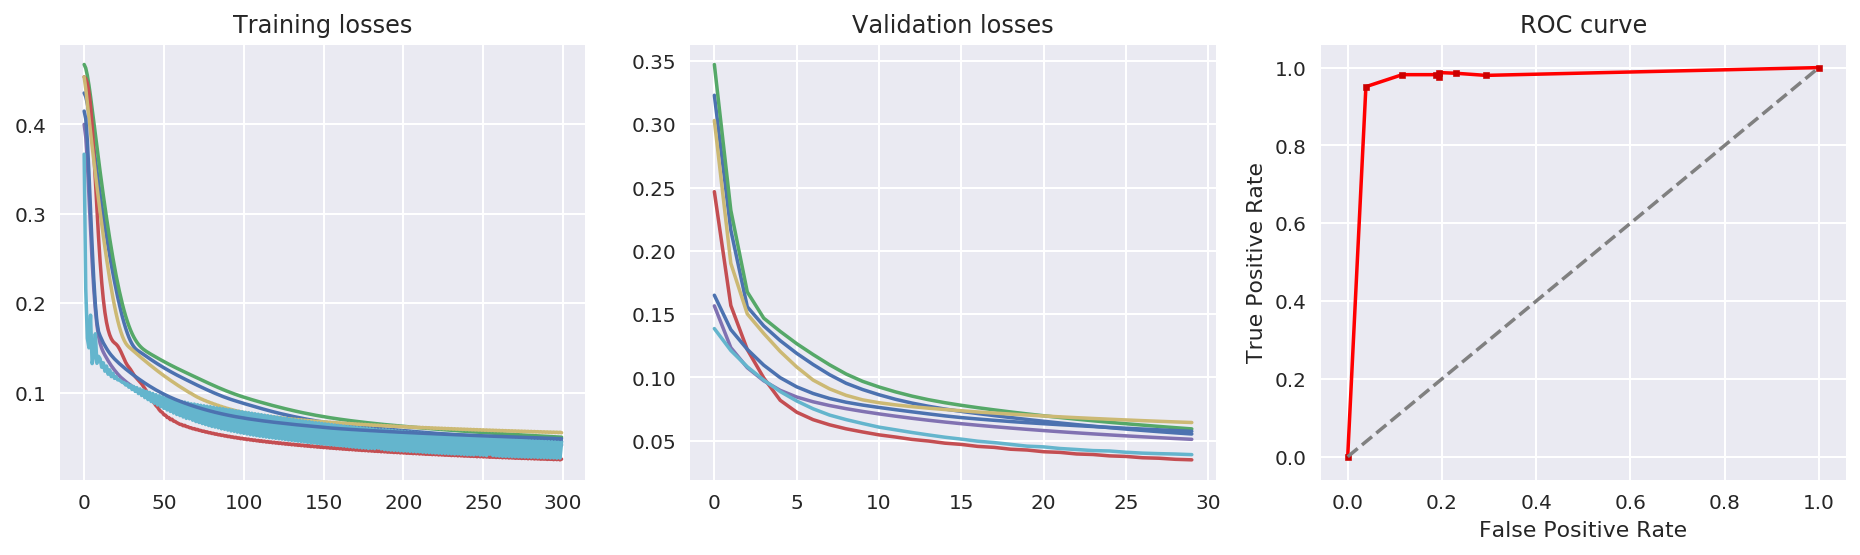

8 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#32 / gen 5]	score is 1.3013188967263063
[#2 / gen 0]	score is 1.391990535340772
[#31 / gen 5]	score is 1.5090883340953196
[#12 / gen 1]	score is 1.51029415876318
[#0 / gen 0]	score is 1.5347105111508281
[#51 / gen 9]	score is 5.211567276027415
[#50 / gen 9]	score is 4000
[#52 / gen 9]	score is 9223372036854775807
[#53 / gen 9]	score is 9223372036854775807
[#54 / gen 9]	score is 9223372036854775807
(9,) (9,)


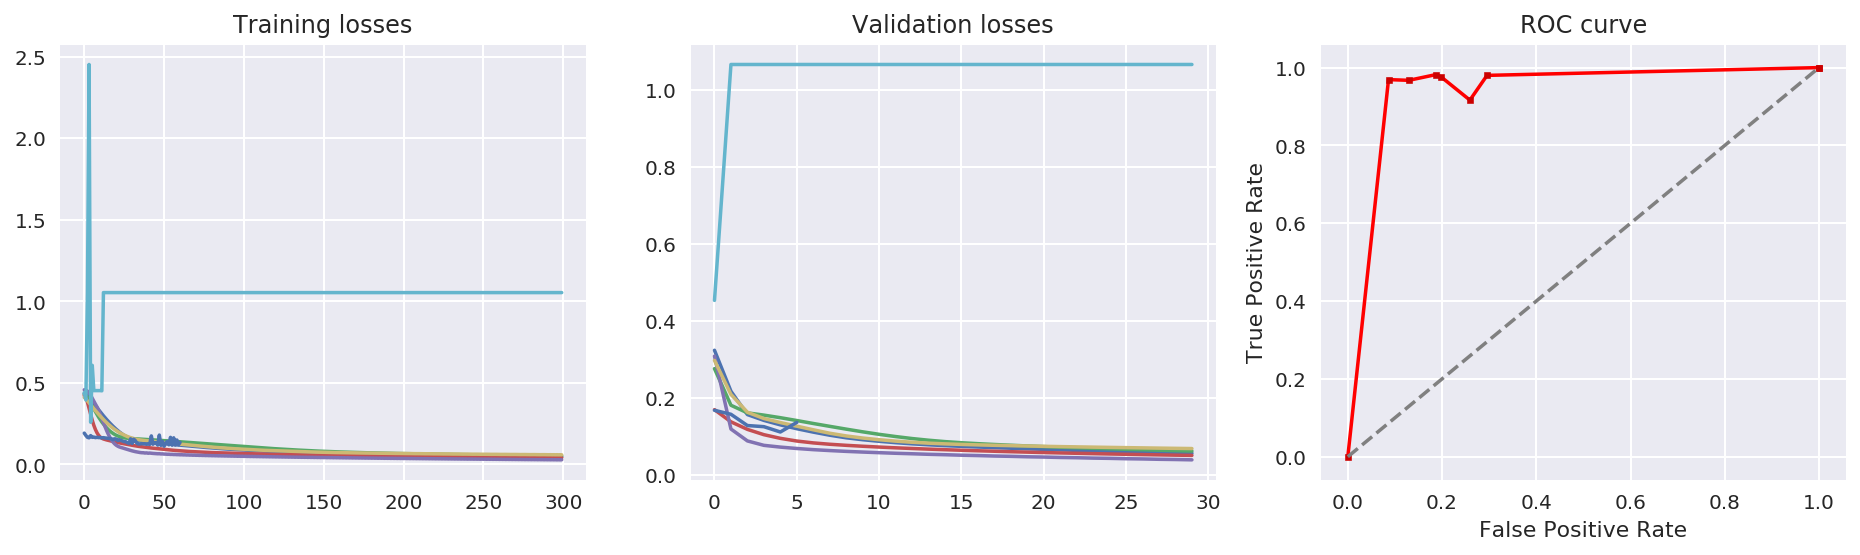

9 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
[#32 / gen 5]	score is 1.3013188967263063
[#0 / gen 0]	score is 1.4060007421610816
[#2 / gen 0]	score is 1.4186623676989278
[#12 / gen 1]	score is 1.5145636398940114
[#31 / gen 5]	score is 1.541329010246039
[#55 / gen 10]	score is 4000
[#56 / gen 10]	score is 4000
[#57 / gen 10]	score is 9223372036854775807
[#58 / gen 10]	score is 9223372036854775807
[#59 / gen 10]	score is 9223372036854775807
(9,) (9,)


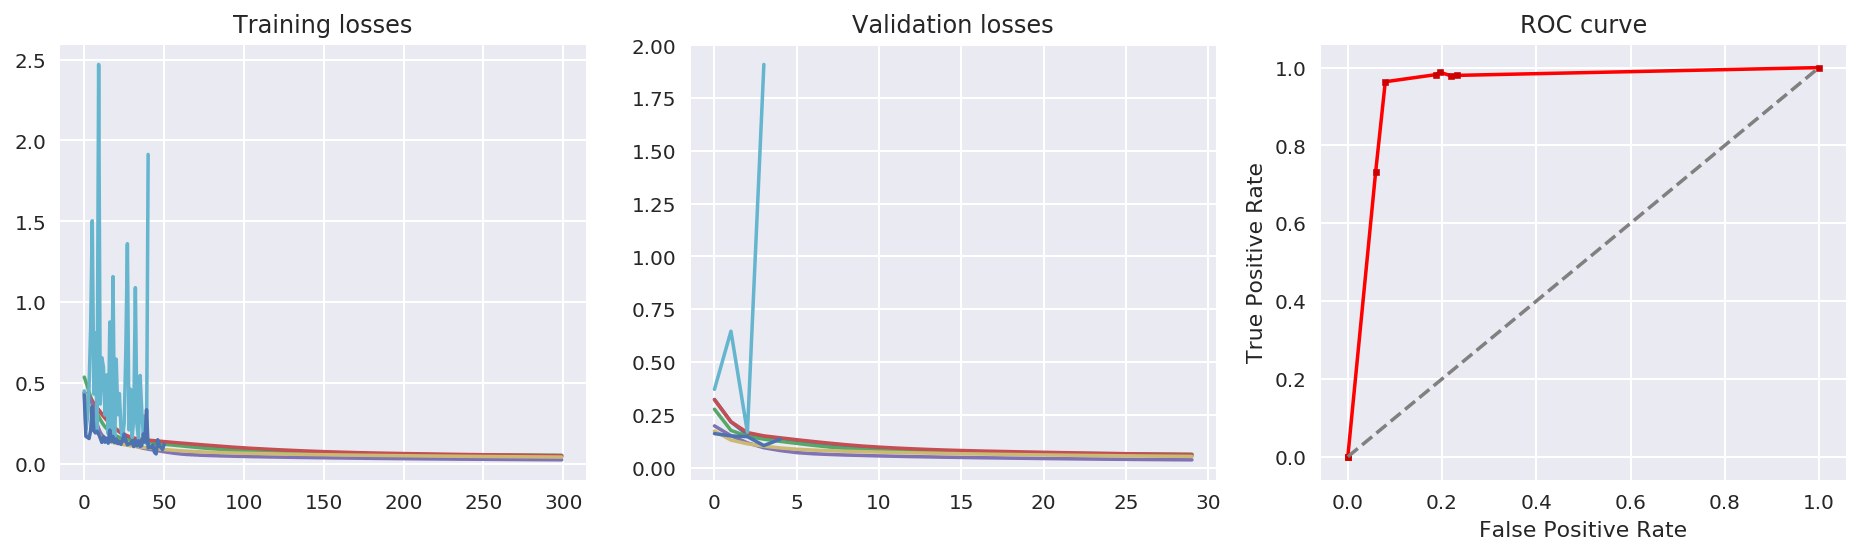

evaluation: 100.00%	(10 over 10)


<IPython.core.display.Javascript object>

In [33]:
ev.evolve(10, callback)
ev.evaluate(display=True)

### Display the best player in the game

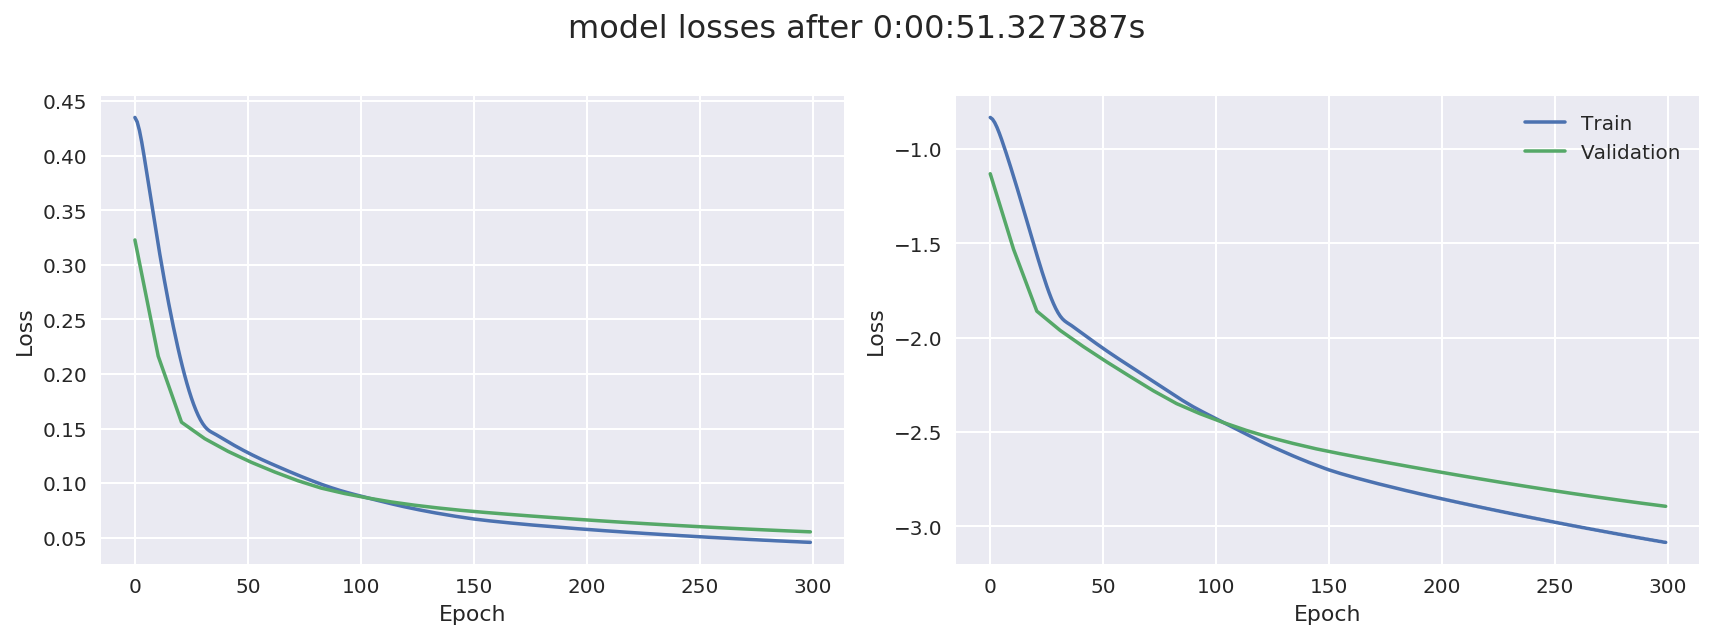

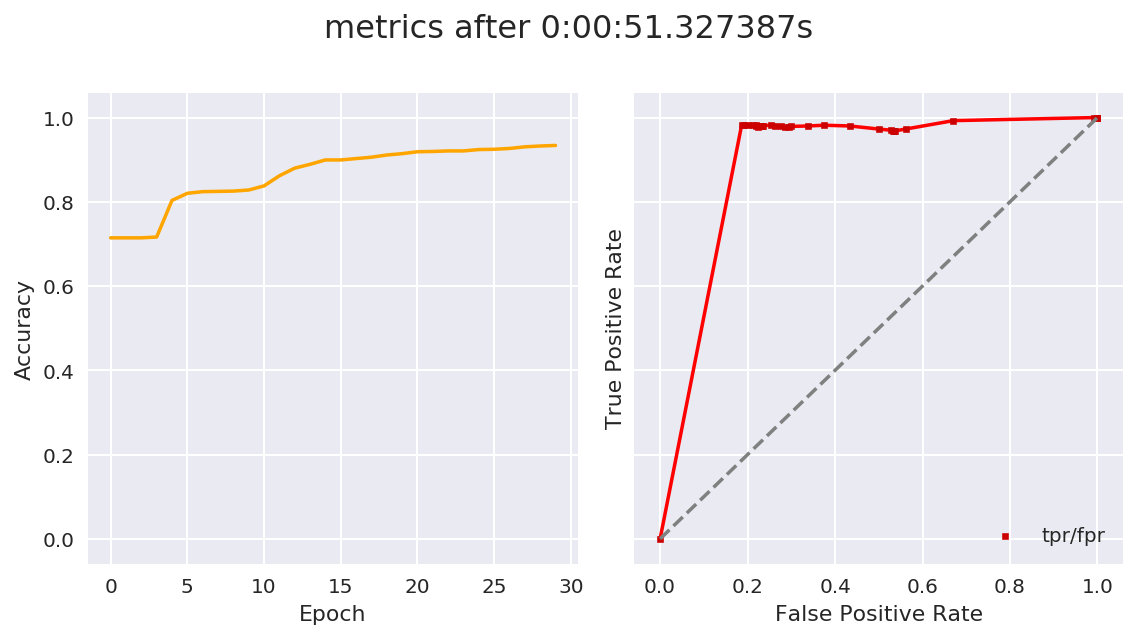

[#32 / gen 5]	score is 1.3013188967263063
		train_loss 0.045746364
		validation_loss 0.05537845


In [34]:
elite = ev.elite
elite.obj.display_losses()
elite.obj.display_metrics()
plt.show()

print(elite)
print("\t\ttrain_loss", elite.obj.train_losses[-1])
print("\t\tvalidation_loss", elite.obj.validation_losses[-1])

Hyperparameters:

In [35]:
elite.dna

{'activation': 'linear',
 'hidden_size_1': 55,
 'hidden_size_2': 37,
 'hidden_size_3': 12,
 'learning_rate': 0.00011529392786880891,
 'lr_decay': 0.00413819623212028,
 'momentum': 0.5633738434783578}

Test the accuracy and get the metrics:

In [36]:
elite.obj.test(X_test, y_test)

{'accuracy': 0.9338092147955873,
 'error': 0.06619078520441268,
 'false_negative': 20,
 'false_positive': 82,
 'false_positive_rate': 0.18636363636363637,
 'true_negative': 358,
 'true_positive': 1081,
 'true_positive_rate': 0.9818346957311535}

Fitness score composition:

In [37]:
analyze_fitness_components(elite.obj)

,accuracy_emphasized,mean_epoch_time,train_loss,validation_loss
value,1.0291,0.171091,0.0457464,0.0553784
fitness,1.06993,1.06993,1.06993,1.06993
percentage,96.2%,16.0%,4.3%,5.2%


### Analyze how parameters influences

The visual analysis will help us to understand which values were generated and **how they are correlated to the success of the fitness score.**
Each color represent a different model. Each point is bigger when its individual is from a recent generation: **hopefully we should see bigger circles on the left, where the score is good, than on the right**. The elite is shown by the star icon.

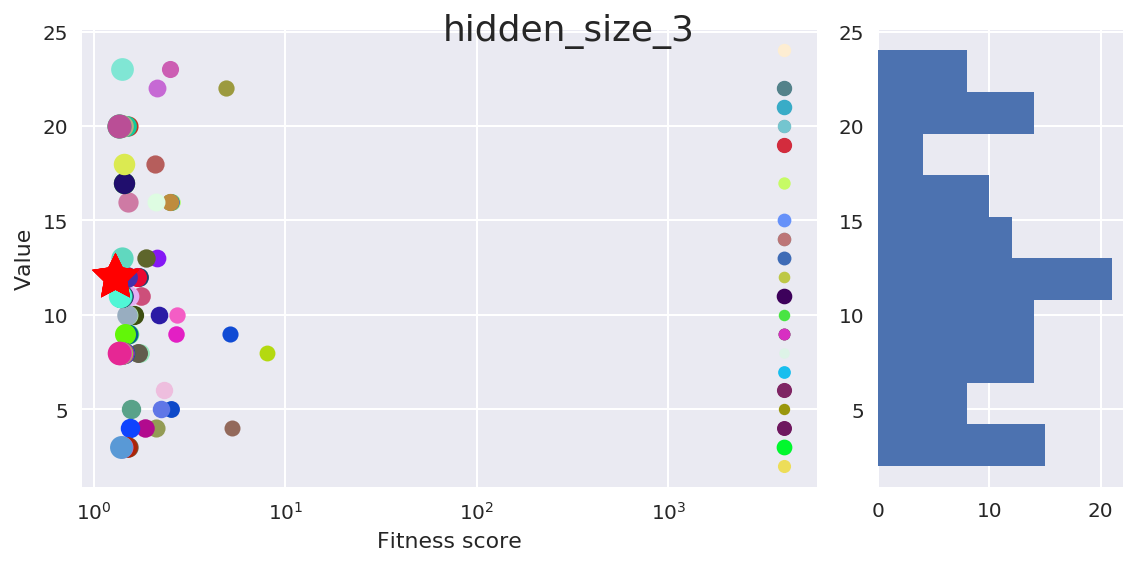

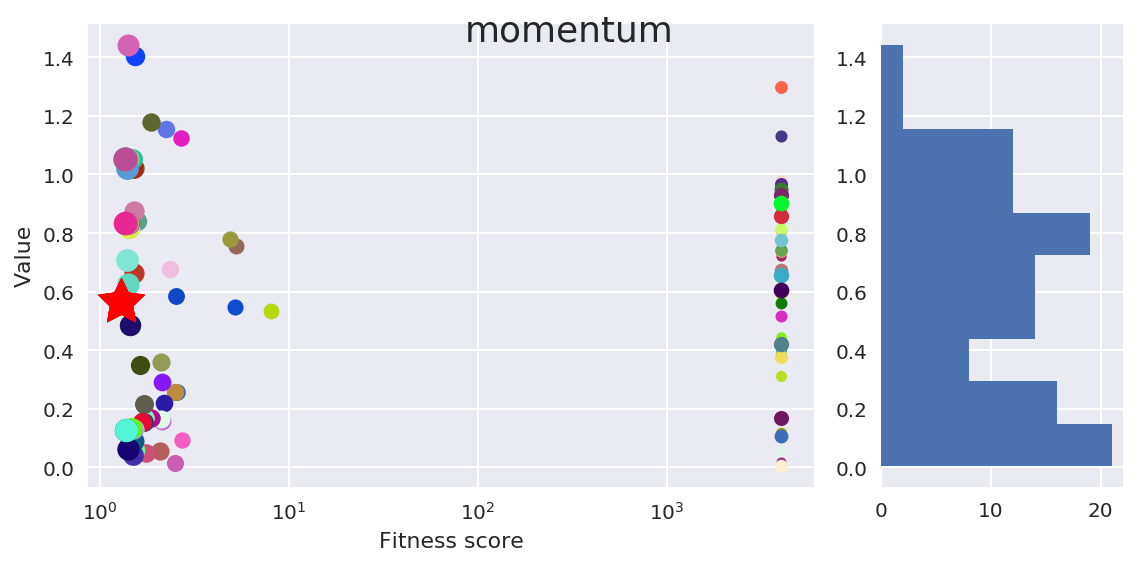

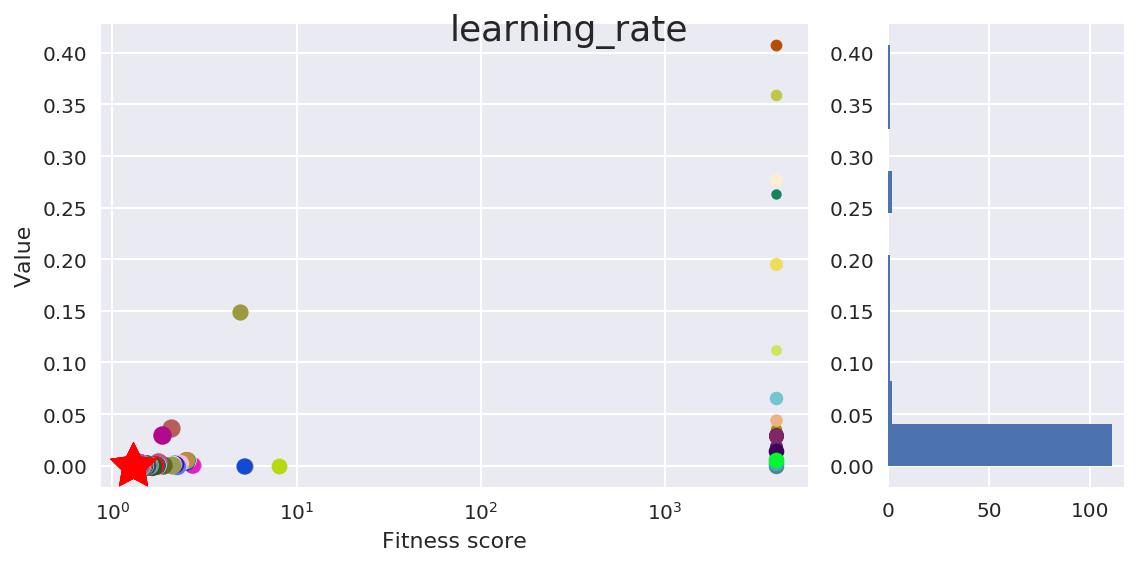

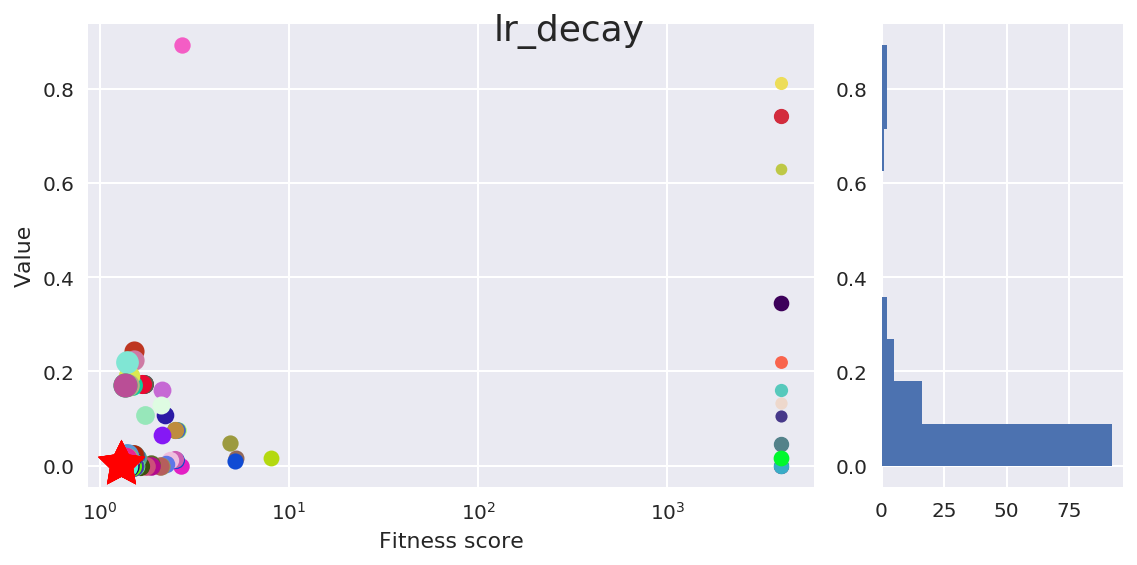

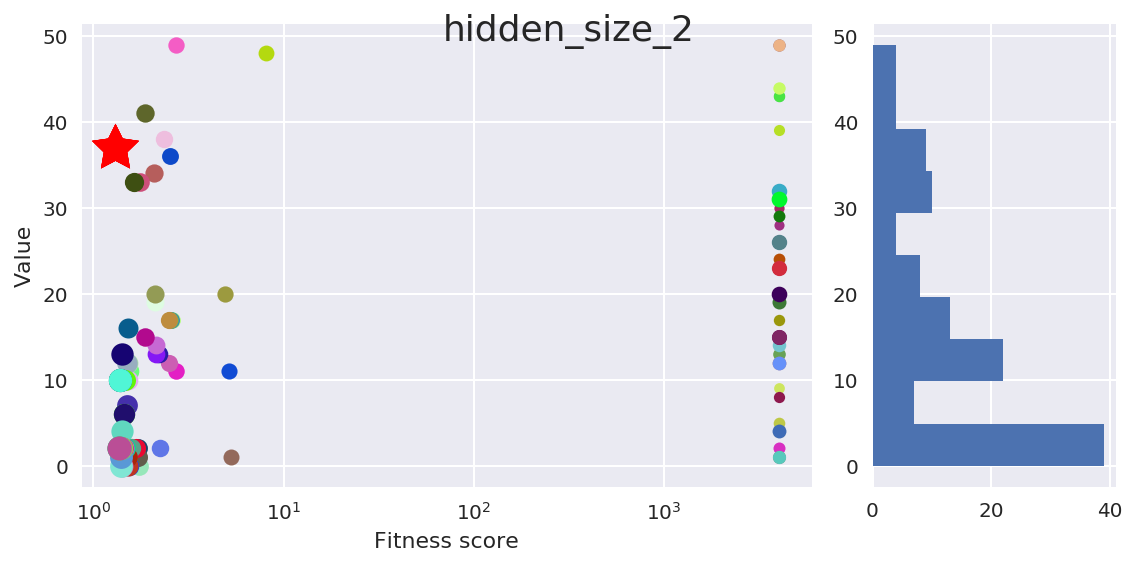

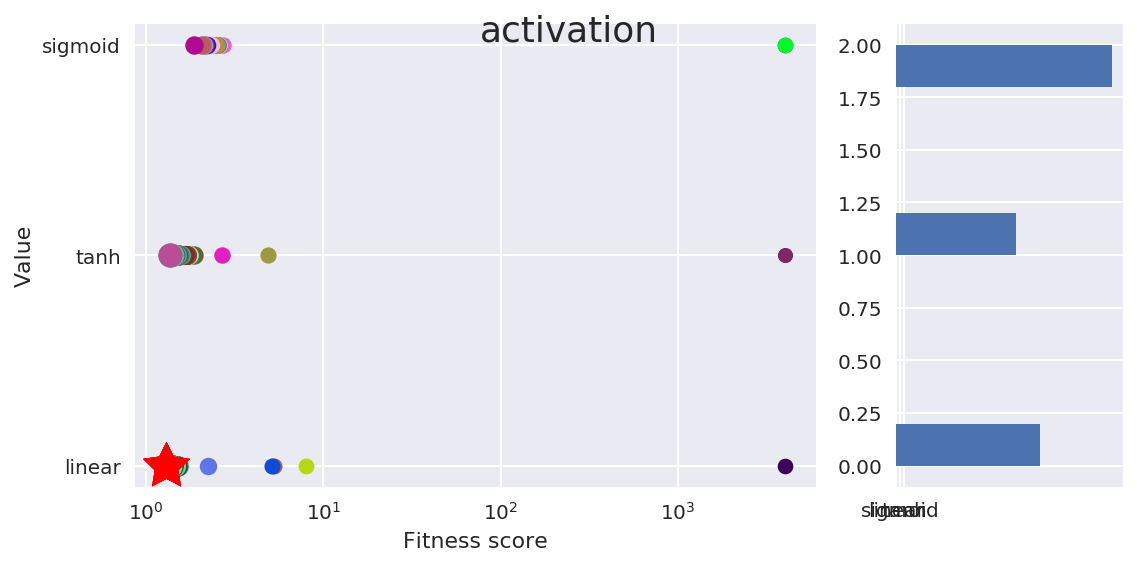

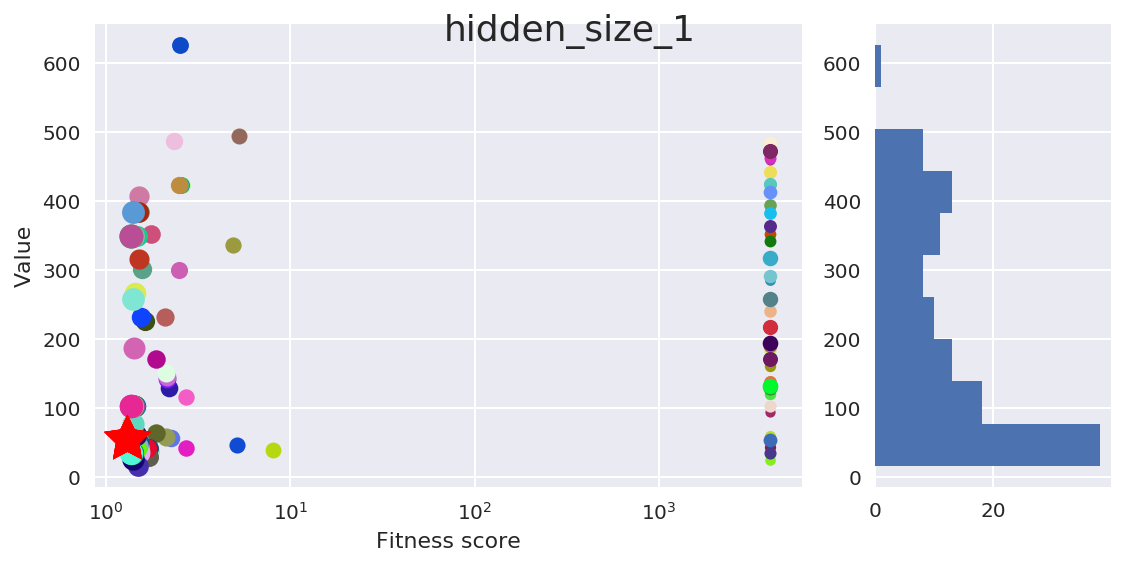

In [38]:
ev.visual_analysis()

As we can see, the `learning_rate` and the `lr_decay` are always a really low values and we could definitively lower the maximum pickable value. However, it is interesting to see that a value like the `hidden_size` has been tested through a lot of different possibilities.   
The fact that we don't have the distribution of every parameter around the values of the elite components **shows the sanity of the genetic algorithm**. However, we lack of time information and the genetic algorithm may be blocked into a local minimum.  

## Final training on the entire dataset
Now that we have our best model, we can try to train it on the whole dataset. As a reminder, we did used only 10% of the dataset in order to speed up the training, validation and test, and so the genetic evolution.  

In [39]:
ALL_X_train, ALL_y_train, ALL_X_val, ALL_y_val, ALL_X_test, ALL_y_test = cross_validation_split(X_all, y_all)

X_.shape	 (7707, 5971) 	 y_.shape	 (7707, 2)
X_train.shape	 (4624, 5971) 	 y_train.shape	 (4624, 2)
X_val.shape	 (1541, 5971) 	 y_val.shape	 (1541, 2)
X_test.shape	 (1541, 5971) 	 y_test.shape	 (1541, 2)


Here are the *best* hyperparameters, according to the genetic evolution: 

In [40]:
optimal_hyperparameters = elite.dna
optimal_hyperparameters

{'activation': 'linear',
 'hidden_size_1': 55,
 'hidden_size_2': 37,
 'hidden_size_3': 12,
 'learning_rate': 0.00011529392786880891,
 'lr_decay': 0.00413819623212028,
 'momentum': 0.5633738434783578}

### Launch the training

In [41]:
m2 = Model(**optimal_hyperparameters)
m2.epochs_between_reports = 10
train_losses, val_loss, metrics, t = m2.fit(ALL_X_train, ALL_y_train, ALL_X_val, ALL_y_val, ALL_X_test, ALL_y_test, 
                                            epochs=1000, batch_size=512, early_stopping=False, verbose=True)

epoch #10	loss: 0.1036 / 0.1009	acc: 0.83
epoch #20	loss: 0.0615 / 0.0695	acc: 0.90
epoch #30	loss: 0.0501 / 0.0590	acc: 0.92
epoch #40	loss: 0.0428 / 0.0522	acc: 0.94
epoch #50	loss: 0.0377 / 0.0474	acc: 0.94
epoch #60	loss: 0.0336 / 0.0438	acc: 0.95
epoch #70	loss: 0.0306 / 0.0410	acc: 0.96
epoch #80	loss: 0.0282 / 0.0390	acc: 0.96
epoch #90	loss: 0.0264 / 0.0375	acc: 0.96
epoch #100	loss: 0.0250 / 0.0364	acc: 0.96
epoch #110	loss: 0.0238 / 0.0354	acc: 0.96
epoch #120	loss: 0.0228 / 0.0346	acc: 0.97
epoch #130	loss: 0.0219 / 0.0340	acc: 0.97
epoch #140	loss: 0.0212 / 0.0334	acc: 0.97
epoch #150	loss: 0.0205 / 0.0329	acc: 0.97
epoch #160	loss: 0.0199 / 0.0324	acc: 0.97
epoch #170	loss: 0.0193 / 0.0320	acc: 0.97
epoch #180	loss: 0.0188 / 0.0316	acc: 0.97
epoch #190	loss: 0.0184 / 0.0313	acc: 0.97
epoch #200	loss: 0.0179 / 0.0310	acc: 0.97
epoch #210	loss: 0.0175 / 0.0307	acc: 0.97
epoch #220	loss: 0.0172 / 0.0305	acc: 0.97
epoch #230	loss: 0.0168 / 0.0303	acc: 0.97
epoch #240	loss: 0.0

<IPython.core.display.Javascript object>

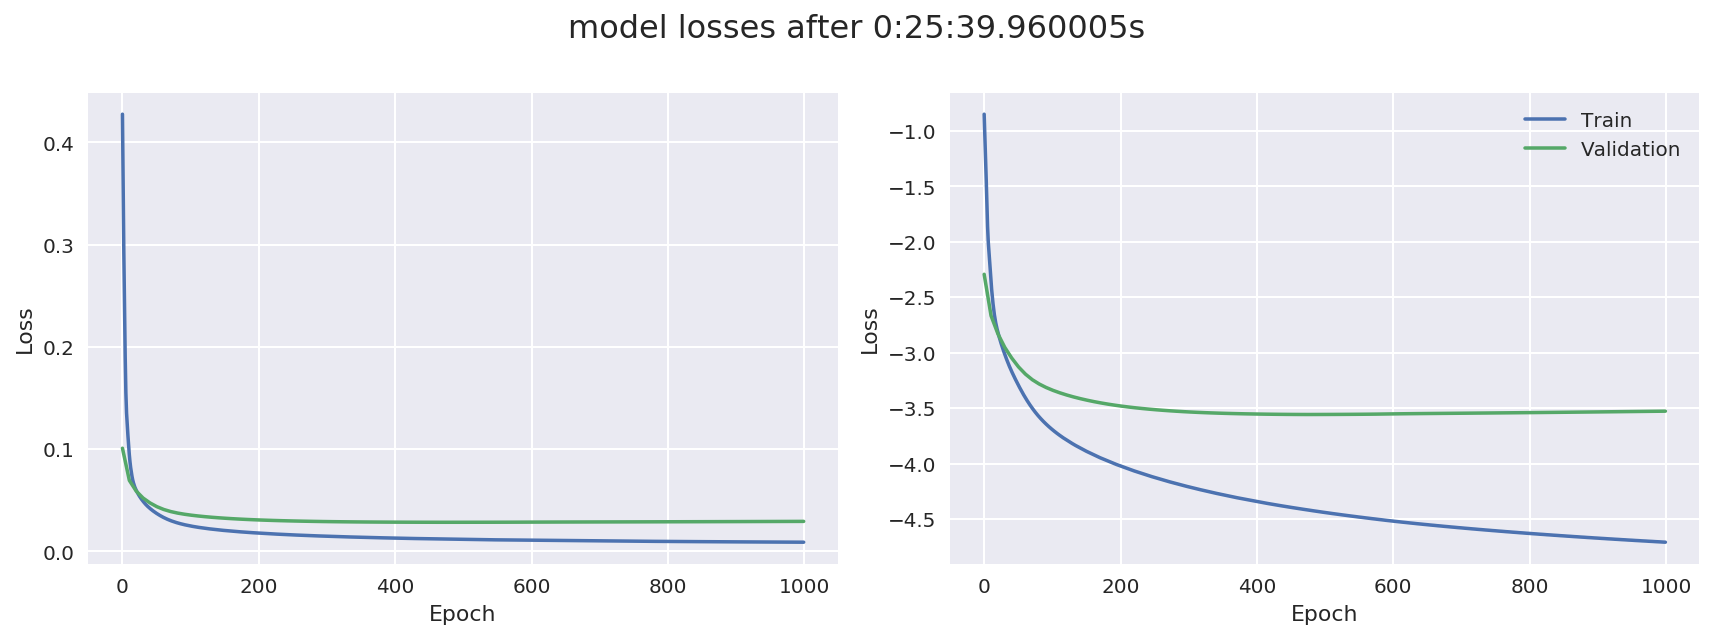

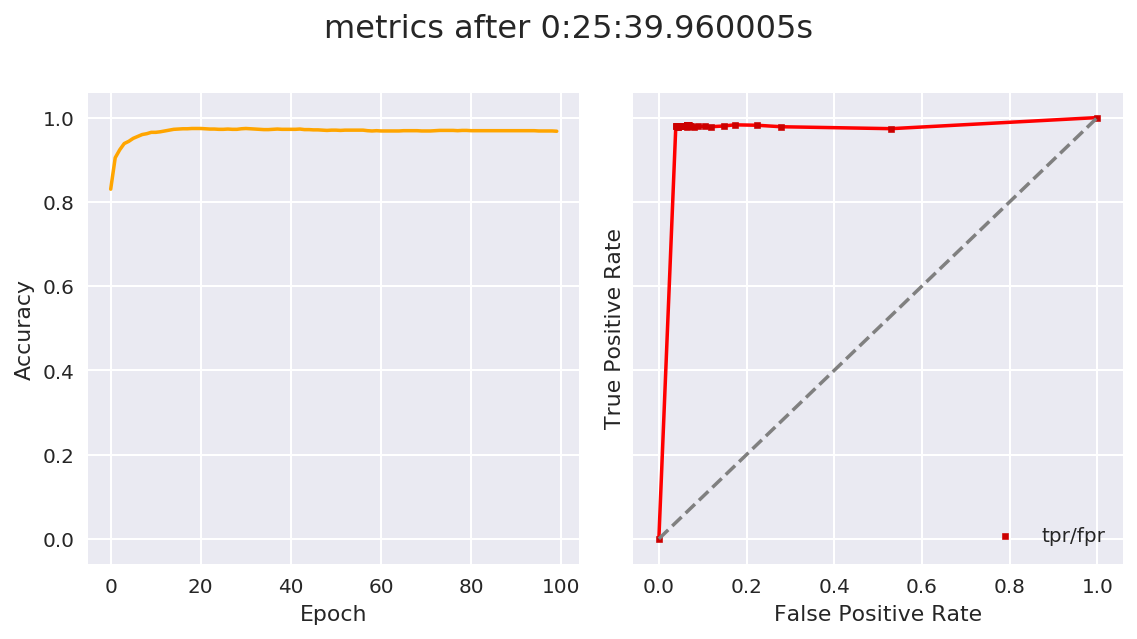

'live'

In [42]:
m2.display_losses()
m2.display_metrics()
m2.status

In [43]:
m2.test(X_test, y_test)

{'accuracy': 0.9675535366645036,
 'error': 0.03244646333549639,
 'false_negative': 20,
 'false_positive': 30,
 'false_positive_rate': 0.06818181818181818,
 'true_negative': 410,
 'true_positive': 1081,
 'true_positive_rate': 0.9818346957311535}

### Analysis of the results
As said before, the batch_size really influences the precision but also the time took for a model to get a high precision. With the above model, we obtained several accuracies given the batch_size:
- 0.95 (**TPR = 0.974**) with `bath_size = None` (the dataset size, so 7707)
- 0.97 (**TPR = 0.983**) with `batch_size = 512` 
- 0.97 (**TPR = 0.986**) with `batch_size = 32` but it was way longer than the previous one.

The accuracy graph ROC curve really shows how the neural network converges towards a higher rate of True Positives but **can't really go over 99%**. 

# Conclusion

The goal of this project was to build a feed-forward neural network able to classify an input of being a malware or not. We used a genetic algorithm in order to find the best hyperparameters for the model.  
We trained this genetic algorithm through 10 evolutions, each with a population of 10 different models.    

We first did a cross-validation on 10% of the dataset to speed-up the set-up and examine how the genetic evolution can help us. The results were good but and when we finally trained the genetic algorithm on the whole dataset (again, using cross-validation, so the training set was not exactly 100%), the accuracy jumped again.  

The real advantage of the genetic algorithm here was to be able to give an appropriate solution depending on amount of dataset inputs, the batch size (which helped us to speed-up the development of the overall project) and all the possible hyperparameters for this classification problem. In other words, it was **its ability to adapt the models given the environment**, so we didn't have to re-test every combination of parameters each time that we changed something.

>Our results with the best found model reached an accuracy of 0.97 with:
>- 1083 correctly classified as *malwares*, 18 missed (True Positive Rate = 98.36%)
>- 417 correctly classified as *benigns*, 23 missed (False Positive Rate = 5.22%)

### Limitations of the genetic evolution

The randomness of this algorithm which makes its power can also lead to bad results. For example, it is possible to be stuck in a local optimum even if we continue to evolve and mutate the population over 40 generations: this is often due to the first random generation of a too good model which blocks the population to improve itself, even with mutations. There are two options to solve that:
* We can choose, after a given threshold time, to mutate the elite itself (but we may go backwards and lose a good population if no other elites stands out from the crowd)
* Since the crossover is always made with the same elite, we could try to do a crossover with maybe 3 individuals instead of two.

### Possible improvements

One way of improving this model would be to train on more data. As well, the way that we create new models could be also improved: 
* We could set the value a highly-correlated hyperparameter in order to optimize the associated other one. For example, we stabilize the number of hidden layers when we obtain a correct value and then focus on the number of neurons on each layer.
* We could also set the value of hyperparameters like the learning rate and its decay (which was really low in every evolution) in order to give fewer choices and avoid picking randomly non-efficient configurations.
* We could add an option for setting different amount of neurons on each layer and thus to give more freedom (currently, the picked activation function and the hidden size are the same for each hidden layer). 
* When we have our most powerful hyperparameters, we could modify the fitness function and emphasize the time required for the model training, in order to get the most powerful and fastest model. 

The Python implementation of the genetic algorithm may be also improved:
* It could be possible to speed-up the evolution by using multithreading in Python and splitting up a population in as many threads as it contains different models. 